<h1 style="color: green;">Summary</h1>
<p style="color: black;">
In this section data is pulled from the database and cleaned then feature engineering is performed<br>
to create new features in preparation for modelling.
</p>


<h1 style="color: green;">Importing libraries</h1>

In [4]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# SQLAlchemy==1.4.35
import sqlalchemy

# OneHotEncoder for encoding Venue
from sklearn.preprocessing import OneHotEncoder

# RidgeCV for preliminary feature importance
from sklearn.linear_model import RidgeCV

<h5 style="color: green;">Loading environment variables</h5>

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
# connecting to MySQL database using URL connection string
sqlUrl = sqlalchemy.engine.URL.create(
    drivername = os.getenv('drivername'),
    username = os.getenv('username'),
    password = os.getenv('password'),
    host = os.getenv('host'),
    port = os.getenv('port'),
    database = os.getenv('database')
)

engine = sqlalchemy.create_engine(sqlUrl)

<h5 style="color: green;">Reading data</h5>

In [7]:
# Reading receipt table
# Receipt = pd.read_sql_table("receipt", engine,index_col='Receipt_id')

Receipt = pd.read_sql_table("receipt", engine)

print(Receipt.shape)
Receipt.tail()


(844, 10)


,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added
839,850,8,1,1.80,14032023092400,0,0,2023-03-14,09:24:00,2023-03-16 09:02:39
840,851,36,5,19.40,11032023185759,0,0,2023-03-11,18:57:59,2023-03-16 09:22:50
841,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33
842,853,6,1,2.50,16032023164200,0,0,2023-03-16,16:42:00,2023-03-16 19:00:07
843,854,15,1,40.00,16032023171027,0,0,2023-03-16,17:10:27,2023-03-16 19:02:55


In [8]:
print(f"Shape: {Receipt.shape}")

Shape: (844, 10)


In [9]:
Receipt.columns

Index(['Receipt_id', 'Venue_id', 'Total_Nbr_of_Items', 'Total_Price',
       'Receipt_Nbr', 'Trans_number', 'Barcode', 'Receipt_Date',
       'Receipt_Time', 'Date_Added'],
      dtype='object')

In [10]:
Venue_details = pd.read_sql_table("venue_details", engine)

Venue_details[['Venue_id','Venue']].head(15)

,Venue_id,Venue
0,1,Aldi
1,2,B&Q
2,3,Wilko
3,4,Sports direct.com
4,5,Europe
5,6,Primark
6,7,Currys PC World
7,8,Tesco
8,9,Stabana
9,10,Abbey Sports


In [11]:
# Merging Venue_details with Receipt to retrieve Venue
Receipt = pd.merge(Receipt, 
                   Venue_details[['Venue_id','Venue']], 
                   on='Venue_id', how='left')
Receipt.head()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue
0,1,1,8,6.78,1488772027005024,0,0,2020-05-28,11:09:45,2020-07-23 18:25:38,Aldi
1,2,1,9,6.32,1173772027004007,0,0,2020-06-24,12:57:56,2020-07-23 20:25:36,Aldi
2,3,1,9,7.44,6880772027011805,0,0,2020-07-01,14:28:27,2020-07-23 20:51:18,Aldi
3,4,1,12,8.27,7450772027005024,0,0,2020-06-10,13:07:51,2020-07-23 21:13:19,Aldi
4,5,1,11,8.10,3851772027003031,0,0,2020-05-25,11:31:37,2020-07-23 21:30:04,Aldi


<h1 style="color: green;">Data exploration and feature engineering</h1>

<h3 style="color: green;">Exploring receipt data</h3>

In [12]:
# Excluding refunds i.e. negative Total_Price
print(f"The shape with refunds: {Receipt.shape}")
Receipt = Receipt[Receipt.Total_Price > 0]
print(f"The shape without refunds: {Receipt.shape}")

# Checking to see that the exclusion was done correctly
Receipt.query("Total_Price < 0")

The shape with refunds: (844, 11)
The shape without refunds: (827, 11)


,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue


In [13]:
# Deriving the difference in days between shopping trips

# sorting the data in ascending date order
Receipt.sort_values('Receipt_Date',ascending=True, inplace=True)
print(Receipt.shape)

# calculating the date difference using the shift() method to get the lag -1 value
# and retrieving the numeric part of date difference
Receipt['Date_diff'] = (Receipt.Receipt_Date - Receipt.Receipt_Date.shift()).dt.days

# Deriving the weekdate
week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# [week[x.weekday()] for x in Receipt.Receipt_Date]
Receipt['Week_day'] = Receipt.Receipt_Date.apply(lambda x: week[x.weekday()])
print("Shape After weekday calculation",Receipt.shape)
Receipt.tail()

(827, 11)
Shape After weekday calculation (827, 13)


,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue,Date_diff,Week_day
838,849,62,1,7.99,13032023132853,0,0,2023-03-13,13:28:53,2023-03-16 08:53:02,John Lewis,2.0,Monday
839,850,8,1,1.80,14032023092400,0,0,2023-03-14,09:24:00,2023-03-16 09:02:39,Tesco,1.0,Tuesday
841,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33,Asda,1.0,Wednesday
842,853,6,1,2.50,16032023164200,0,0,2023-03-16,16:42:00,2023-03-16 19:00:07,Primark,1.0,Thursday
843,854,15,1,40.00,16032023171027,0,0,2023-03-16,17:10:27,2023-03-16 19:02:55,next,0.0,Thursday


In [14]:
# Retrieving only the numeric version of weekday()
# adding 1 to remove the 0 for the first day
Receipt['Week_day_numeric'] = Receipt.Receipt_Date.apply(lambda x: x.weekday()) + 1
Receipt[['Week_day','Week_day_numeric']].head(15)

,Week_day,Week_day_numeric
96,Friday,5
97,Friday,5
95,Friday,5
142,Wednesday,3
100,Thursday,4
98,Thursday,4
99,Thursday,4
101,Wednesday,3
102,Wednesday,3
103,Wednesday,3


In [15]:
Receipt[['Receipt_Date','Date_diff']].head()

,Receipt_Date,Date_diff
96,2019-09-20,NaN
97,2019-09-20,0.0
95,2019-09-20,0.0
142,2019-09-25,5.0
100,2019-09-26,1.0


In [16]:
type(Receipt['Date_diff'][0])

numpy.float64

In [17]:
type(Receipt.Receipt_Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
# concatenate year and week to retrieve week of the year
Receipt['week_of_year'] = Receipt.Receipt_Date.dt.isocalendar().year.map(str)+ "_" +  \
Receipt.Receipt_Date.dt.isocalendar().week.map(str)
Receipt.head(3)

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue,Date_diff,Week_day,Week_day_numeric,week_of_year
96,100,12,1,2.98,0,0,05-03896-06921,2019-09-20,13:10:00,2020-11-02 17:34:49,eBay,NaN,Friday,5,2019_38
97,101,12,1,3.29,0,0,05-03896-06922,2019-09-20,13:10:00,2020-11-02 17:45:31,eBay,0.0,Friday,5,2019_38
95,99,12,1,10.89,0,0,25-03894-02600,2019-09-20,11:24:00,2020-11-02 17:23:49,eBay,0.0,Friday,5,2019_38


In [19]:
Receipt[['Receipt_id','Receipt_Date','week_of_year']].tail(10)

,Receipt_id,Receipt_Date,week_of_year
836,847,2023-03-04,2023_9
832,843,2023-03-04,2023_9
834,845,2023-03-05,2023_9
837,848,2023-03-11,2023_10
840,851,2023-03-11,2023_10
838,849,2023-03-13,2023_11
839,850,2023-03-14,2023_11
841,852,2023-03-15,2023_11
842,853,2023-03-16,2023_11
843,854,2023-03-16,2023_11


In [20]:
# Calculate the number of trips per week
Receipt['Nbr_trips_per_wk'] = Receipt.groupby(['week_of_year'])['Receipt_id'].transform('count')

# Calculate number of items bought per week
Receipt['Nbr_items_per_wk'] = Receipt.groupby(['week_of_year'])\
                            ['Total_Nbr_of_Items'].transform('sum')

# Calculating receipt Total_Nbr_of_Items as a percentage of the weeks Total_Nbr_of_Items 
Receipt['Nbr_items_wk_perc'] = Receipt.Total_Nbr_of_Items / Receipt.Nbr_items_per_wk

# Calculate expenditure per week
Receipt['Expenditure_per_wk'] = Receipt.groupby(['week_of_year'])['Total_Price'].transform('sum')

# Calculating receipt Total_Price as a percentage of the weeks expenditure
Receipt['Total_Exp_wk_perc'] = Receipt.Total_Price / Receipt.Expenditure_per_wk
Receipt.head(3)

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue,Date_diff,Week_day,Week_day_numeric,week_of_year,Nbr_trips_per_wk,Nbr_items_per_wk,Nbr_items_wk_perc,Expenditure_per_wk,Total_Exp_wk_perc
96,100,12,1,2.98,0,0,05-03896-06921,2019-09-20,13:10:00,2020-11-02 17:34:49,eBay,NaN,Friday,5,2019_38,3,3,0.333333,17.16,0.173660
97,101,12,1,3.29,0,0,05-03896-06922,2019-09-20,13:10:00,2020-11-02 17:45:31,eBay,0.0,Friday,5,2019_38,3,3,0.333333,17.16,0.191725
95,99,12,1,10.89,0,0,25-03894-02600,2019-09-20,11:24:00,2020-11-02 17:23:49,eBay,0.0,Friday,5,2019_38,3,3,0.333333,17.16,0.634615


<h3 style="color: green;">Creating trips_response</h3>

<p style="color: black;">
This is  a binary response(target) feature/variable.<br>
If the number of trips per week is less than a threshold then 1 else 0
</p>

In [21]:
# Printing the value counts for Nbr_trips_per_wk 
# This will aid the decision as to how to how to classify the response target
Nbr_trips_per_wk_pivot = pd.pivot_table(Receipt, 
                           index='Nbr_trips_per_wk',
                           values='Receipt_id', 
                           aggfunc='count')
Nbr_trips_per_wk_pivot

,Receipt_id
Nbr_trips_per_wk,
1,11
2,30
3,54
4,100
5,180
6,144
7,56
8,48
9,54


In [22]:
Receipt['Trips_response_lt_4'] = Receipt.Nbr_trips_per_wk.apply(lambda x: 1 if x < 4 else 0)
Receipt['Trips_response_lt_5'] = Receipt.Nbr_trips_per_wk.apply(lambda x: 1 if x < 5 else 0)
Receipt['Trips_response_lt_6'] = Receipt.Nbr_trips_per_wk.apply(lambda x: 1 if x < 6 else 0)

Receipt[['week_of_year',
         'Nbr_trips_per_wk',
         'Trips_response_lt_4']].query("Trips_response_lt_4==1").tail()

,week_of_year,Nbr_trips_per_wk,Trips_response_lt_4
817,2023_5,3,1
824,2023_7,2,1
825,2023_7,2,1
837,2023_10,2,1
840,2023_10,2,1


In [23]:
# Displaying the frequencies for each response feature
response_pivot = pd.pivot_table(Receipt, 
                           index='Trips_response_lt_4',
                           values='Receipt_id', 
                           aggfunc='count')
response_pivot

,Receipt_id
Trips_response_lt_4,
0,732
1,95


In [24]:
# Displaying the frequencies for each response feature
response_pivot = pd.pivot_table(Receipt, 
                           index='Trips_response_lt_5',
                           values='Receipt_id', 
                           aggfunc='count')
response_pivot

,Receipt_id
Trips_response_lt_5,
0,632
1,195


In [25]:
# Displaying the frequencies for each response feature
response_pivot = pd.pivot_table(Receipt, 
                           index='Trips_response_lt_6',
                           values='Receipt_id', 
                           aggfunc='count')
response_pivot

,Receipt_id
Trips_response_lt_6,
0,452
1,375


In [26]:
Receipt.shape

(827, 23)

<h3 style="color: Green;">Working with imbalanced data</h3>
<p style="color: black;">
Classification models have a bias that predicts best the class with the largest number<br>
of observations. So it is important to select a response feature that is well represented<br>
in the data to generate adequate predictions:<br><br>
Trips_response_lt_4 has the smallest representation of the target 95(11%), not as desireable <br>for modelling purposes.<br><br>
However, 4 trips per week is practically ideal as it minimises the number of trips despite the lowering of<br>target, response of interest number of observations i.e. I prefer to do less running around shopping<br><br>    
Trips_response_lt_6 has the largest representation of the target 375(45%) this is excellent <br> as almost 50% of the observations are the response of interest.<br>
However, the inclusion of 5 trips a week is too many when I am considering optimizing the<br>
number of trips per week.<br><br>
Trips_response_lt_5 is the middle ground with representation of the target 195(24%).<br>
So modelling Trips_response_lt_5 is preferred.
</p>
<p style="color: black;"><b>
Later on, we will balance the training dataset with oversampling method<br>
and then re-run the models for comparison.</b>
</p>

In [27]:
Trips_per_week_ = pd.pivot_table(Receipt, index='Nbr_trips_per_wk', 
               columns='Trips_response_lt_5', 
               values='Venue_id',
               aggfunc='count').fillna(0)

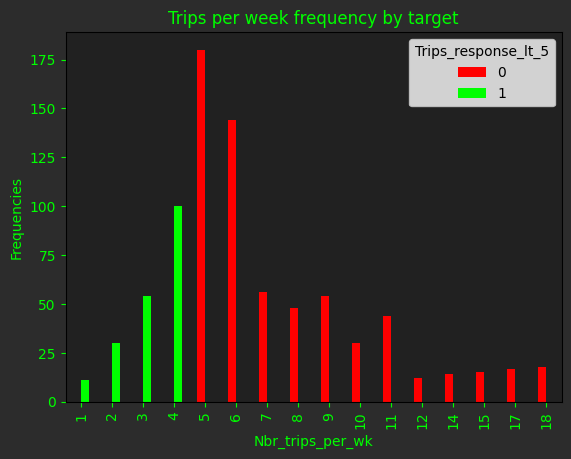

In [28]:
# plotting the above for visual illustration
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

Trips_per_week_.plot(ax=ax,
                kind='bar', 
                ylabel='Frequencies',
                title='Trips per week frequency by target', 
                color=['red','lime'])
plt.show()

<h3 style="color: green;">Checking to see which part of the day I mainly shop</h3>

In [29]:
# extract the time of day as morning, afternoon, evening etc
Receipt['hour'] = Receipt['Receipt_Time'].apply(lambda x: x.hour)

bins_= [0,7,11,17,20,23]
lbl = ['Early','Morning','Afternoon','Evening','Late_night']

Receipt['Part_of_day'] = pd.cut(Receipt['hour'],bins=bins_, labels=lbl, include_lowest=True)

Receipt.tail()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,...,Nbr_trips_per_wk,Nbr_items_per_wk,Nbr_items_wk_perc,Expenditure_per_wk,Total_Exp_wk_perc,Trips_response_lt_4,Trips_response_lt_5,Trips_response_lt_6,hour,Part_of_day
838,849,62,1,7.99,13032023132853,0,0,2023-03-13,13:28:53,2023-03-16 08:53:02,...,5,17,0.058824,67.1,0.119076,0,0,1,13,Afternoon
839,850,8,1,1.80,14032023092400,0,0,2023-03-14,09:24:00,2023-03-16 09:02:39,...,5,17,0.058824,67.1,0.026826,0,0,1,9,Morning
841,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33,...,5,17,0.764706,67.1,0.220715,0,0,1,11,Morning
842,853,6,1,2.50,16032023164200,0,0,2023-03-16,16:42:00,2023-03-16 19:00:07,...,5,17,0.058824,67.1,0.037258,0,0,1,16,Afternoon
843,854,15,1,40.00,16032023171027,0,0,2023-03-16,17:10:27,2023-03-16 19:02:55,...,5,17,0.058824,67.1,0.596125,0,0,1,17,Afternoon


In [30]:
# Checking the frequencies of part of day
y = Receipt.Part_of_day.value_counts()
y

Afternoon     415
Morning       275
Evening       102
Early          19
Late_night     16
Name: Part_of_day, dtype: int64

<AxesSubplot: title={'center': 'Part of the day'}>

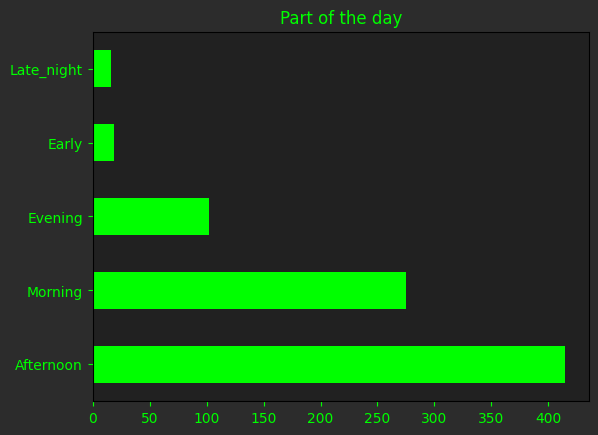

In [31]:
# plotting the frequencies for visual effect

# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

y.plot(ax=ax,
       kind='barh',
       color='lime',
       title="Part of the day")

In [32]:
# showing the breakdown of shopping times by hours
shp_times = pd.pivot_table(Receipt, 
                           index='hour',
                           columns='Part_of_day', 
                           values='Receipt_id', 
                           aggfunc='count')
shp_times

Part_of_day,Early,Morning,Afternoon,Evening,Late_night
hour,,,,,
0,6,0,0,0,0
5,1,0,0,0,0
6,2,0,0,0,0
7,10,0,0,0,0
8,0,108,0,0,0
9,0,44,0,0,0
10,0,61,0,0,0
11,0,62,0,0,0
12,0,0,83,0,0


<AxesSubplot: title={'center': 'Shopping frequency by hours'}, xlabel='hour', ylabel='Frequency'>

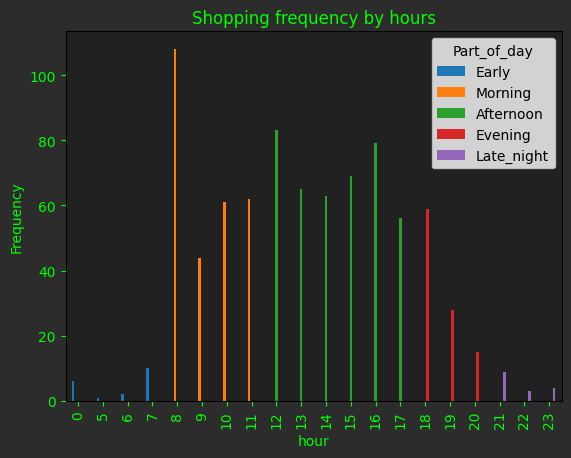

In [33]:
# Plotting shopping times by hours
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

shp_times.plot(ax=ax,
               kind='bar',
               ylabel='Frequency',
               title="Shopping frequency by hours")

<p style="color: black;">
Above, it can be seen that 8am is the single most frequent shopping time.<br>
Note, this is because of direct debits, this will be checked later with payment methods.<br>
Thus 12:00pm is actual most frequent shopping time and also the afternoon is the most<br>
frequent shopping part of day out of all parts of the day.
</p>

<h3 style="color: green;">Checks on the relationship between expenditure and the number of trips per week</h3>

In [34]:
# if I spend more do I have less trips
pd.pivot_table(data=Receipt,
               index='Nbr_trips_per_wk', 
               values='Total_Price', 
               aggfunc='sum')

,Total_Price
Nbr_trips_per_wk,
1,832.53
2,451.77
3,650.20
4,1442.80
5,3161.33
6,1779.46
7,759.53
8,3287.34
9,745.31


In [35]:
# Check the expenditure by number of trips per week and time(Part_of_day) of day
expend_trips_period = pd.pivot_table(data=Receipt,
                                     index='Nbr_trips_per_wk',
                                     columns='Part_of_day', 
                                     values='Total_Price', 
                                     aggfunc='sum')
expend_trips_period

Part_of_day,Early,Morning,Afternoon,Evening,Late_night
Nbr_trips_per_wk,,,,,
1,0.00,785.70,46.83,0.00,0.00
2,0.00,214.33,182.58,54.86,0.00
3,28.66,330.32,222.49,15.07,53.66
4,79.38,558.43,751.36,53.63,0.00
5,54.43,624.51,2145.09,225.98,111.32
6,105.39,668.60,861.53,137.84,6.10
7,62.41,227.38,343.30,126.44,0.00
8,38.97,215.58,2800.50,92.34,139.95
9,65.70,449.57,156.69,73.35,0.00


<AxesSubplot: title={'center': 'Expenditure by number of trips over time of day'}, xlabel='Nbr_trips_per_wk', ylabel='Expenditure (£)'>

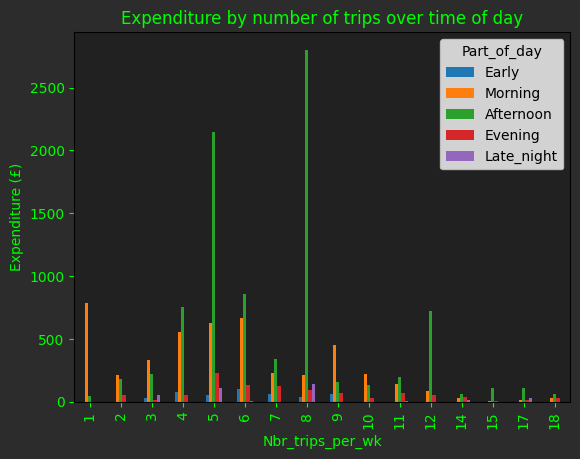

In [36]:
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

expend_trips_period.plot(ax=ax,
                         kind='bar',
                         ylabel='Expenditure (£)',
                         title="Expenditure by number of trips over time of day")

<p style="color: black;">
It can be seen above, there is higher expenditure in the afternoon for the majority of the<br>
categories for number of trips per week.<br>
Thus, I spend more when shopping in the afternoon.
</p>

In [37]:
# Checking the correlation between number of trips per week and expenditure per week
Receipt[['Nbr_trips_per_wk','Expenditure_per_wk']].corr()

,Nbr_trips_per_wk,Expenditure_per_wk
Nbr_trips_per_wk,1.000000,0.175615
Expenditure_per_wk,0.175615,1.000000


<p style="color: black;">Overall there is a very weak correlation between the number of trips per week and expenditure per week.<br>
Thus spending more does not reduce the number of trips per week</p>

<h3 style="color: green;">Checks on relationship between number of items and number of trips</h3>

In [38]:
x = pd.pivot_table(Receipt, 
                   index='Nbr_trips_per_wk', 
                   values='Total_Nbr_of_Items', 
                   aggfunc='sum')
x

,Total_Nbr_of_Items
Nbr_trips_per_wk,
1,61
2,321
3,427
4,704
5,1082
6,796
7,298
8,255
9,300


<AxesSubplot: title={'center': 'Trips per week vs Items per week'}, xlabel='Nbr_trips_per_wk', ylabel='Number of items'>

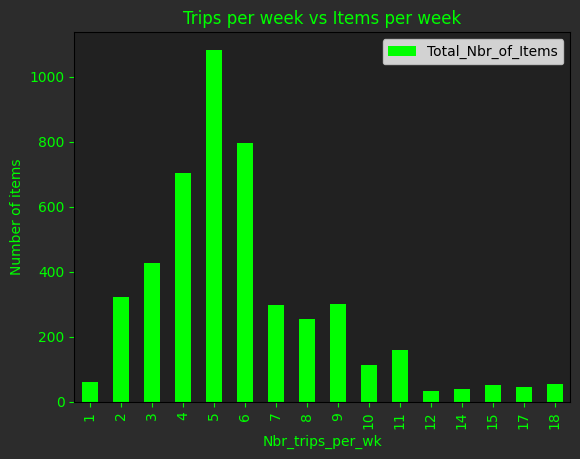

In [39]:
# plotting the above for visual illustrations

# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

x.plot(ax=ax,
       kind='bar',
       ylabel='Number of items',
       color='lime',
       title="Trips per week vs Items per week")

<p style="color: black;">There is an increasing relationship  between the number of trips<br>
and the total number of items bought from 1 to 6,peaking at 5.<br> 
After this point there's a dramatic decrease followed by minor peaks
</p>

In [40]:
# checking the relationship between number of trips per week and total number of items bought
# across time(Part_of_day) of day
x1 = pd.pivot_table(Receipt, index='Nbr_trips_per_wk',
                    columns='Part_of_day', 
                    values='Total_Nbr_of_Items', 
                    aggfunc='sum')
x1

Part_of_day,Early,Morning,Afternoon,Evening,Late_night
Nbr_trips_per_wk,,,,,
1,0,28,33,0,0
2,0,112,191,18,0
3,12,168,220,22,5
4,41,307,310,46,0
5,40,341,499,198,4
6,4,244,407,130,11
7,1,67,180,50,0
8,3,64,135,52,1
9,6,130,108,56,0


<AxesSubplot: title={'center': 'Trips per week vs number of items by time of day'}, xlabel='Nbr_trips_per_wk', ylabel='number of items'>

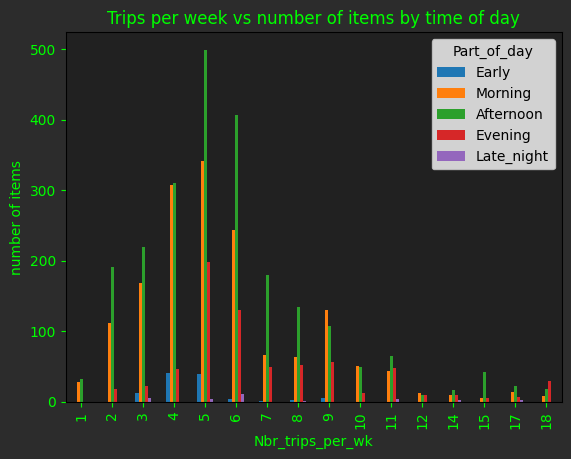

In [41]:
# plotting the above relationships

# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

x1.plot(ax=ax,
        kind='bar',
        ylabel='number of items', 
        title='Trips per week vs number of items by time of day',)


<p style="color: black;">
It's clear from the above that more items are bought in the afternoon than in any other part of the day.<br>
It can also be seen that more items are bought between 2 and 9 shopping trips per week than in the rest


</p>

<h1 style="color: green;">Exploring payment method data</h1>

In [42]:
# Reading payment table
Payment = pd.read_sql_table("payment", engine)
Payment[['Payment_id','Receipt_id','Payment_Type','Card_Source','Date_Added']].head()

,Payment_id,Receipt_id,Payment_Type,Card_Source,Date_Added
0,1,1,Card,Contactless,2020-07-23 18:34:35
1,2,2,Card,Contactless,2020-07-23 20:29:03
2,3,3,Card,Contactless,2020-07-23 20:54:53
3,4,4,Card,Contactless,2020-07-23 21:15:05
4,5,5,Card,Contactless,2020-07-23 21:32:10


In [43]:
# merging Payment to Receipt for the analysis
Receipt_Payment = pd.merge(Receipt, 
                           Payment[['Receipt_id','Payment_Type','Card_Source']], 
                           on='Receipt_id', how='left')


In [44]:
Receipt_Payment.tail()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,...,Nbr_items_wk_perc,Expenditure_per_wk,Total_Exp_wk_perc,Trips_response_lt_4,Trips_response_lt_5,Trips_response_lt_6,hour,Part_of_day,Payment_Type,Card_Source
822,849,62,1,7.99,13032023132853,0,0,2023-03-13,13:28:53,2023-03-16 08:53:02,...,0.058824,67.1,0.119076,0,0,1,13,Afternoon,Card,Contactless
823,850,8,1,1.80,14032023092400,0,0,2023-03-14,09:24:00,2023-03-16 09:02:39,...,0.058824,67.1,0.026826,0,0,1,9,Morning,Cash,0
824,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33,...,0.764706,67.1,0.220715,0,0,1,11,Morning,Card,Contactless
825,853,6,1,2.50,16032023164200,0,0,2023-03-16,16:42:00,2023-03-16 19:00:07,...,0.058824,67.1,0.037258,0,0,1,16,Afternoon,Card,Contactless
826,854,15,1,40.00,16032023171027,0,0,2023-03-16,17:10:27,2023-03-16 19:02:55,...,0.058824,67.1,0.596125,0,0,1,17,Afternoon,Card,Pin


<h3 style="color: green;">Working with Payment_Type</h3>

In [45]:
# checkign overall frequencies by Payment_type
pd.pivot_table(Receipt_Payment, 
               index='Payment_Type', 
               values='Total_Price', aggfunc='count')

,Total_Price
Payment_Type,
Card,766
Cash,58
Plan,3


In [46]:
# checking overall expenditure by Payment_type
rec_pay = pd.pivot_table(Receipt_Payment, 
                         index='Payment_Type', 
                         values='Total_Price', 
                         aggfunc='sum')
rec_pay

,Total_Price
Payment_Type,
Card,13772.41
Cash,242.49
Plan,1327.98


<AxesSubplot: title={'center': 'Expenditure by payment type'}, xlabel='Payment_Type', ylabel='Expenditure (£)'>

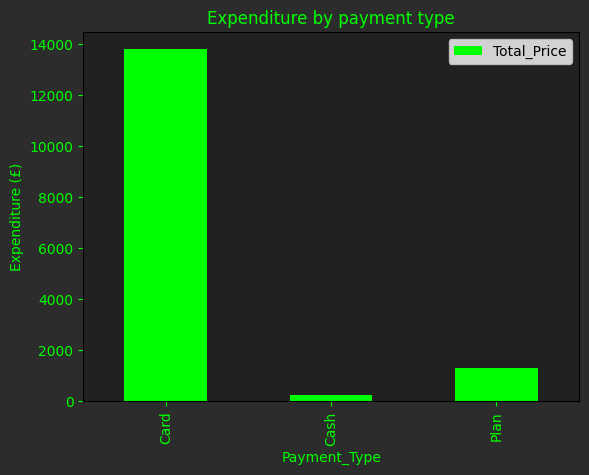

In [47]:
# plotting the above for visual illustration
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

rec_pay.plot(ax=ax,
             kind='bar', 
             ylabel='Expenditure (£)', 
             title='Expenditure by payment type', 
             color=['lime'])

<h3 style="color: green;">Cross check payment type with number of trips per week vs total number of items or item price</h3>

<p style="color: black;">pivot of the cross check with total number of items</p>

In [48]:
R_P = pd.pivot_table(Receipt_Payment, 
                     index='Nbr_trips_per_wk',
                     columns='Payment_Type', 
                     values='Total_Nbr_of_Items', 
                     aggfunc='sum')
R_P

Payment_Type,Card,Cash,Plan
Nbr_trips_per_wk,,,
1,59.0,NaN,2.0
2,321.0,NaN,NaN
3,397.0,30.0,NaN
4,689.0,13.0,2.0
5,1066.0,16.0,NaN
6,759.0,37.0,NaN
7,284.0,14.0,NaN
8,255.0,NaN,NaN
9,293.0,7.0,NaN


<AxesSubplot: title={'center': 'Trips per week vs items bought by payment type'}, xlabel='Nbr_trips_per_wk', ylabel='Item frequencies'>

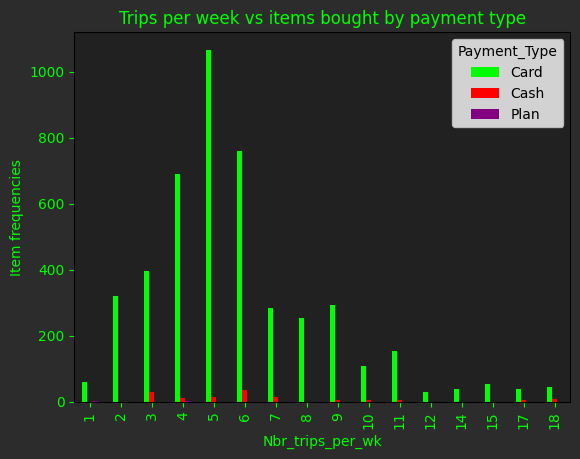

In [49]:
# plotting the above
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

R_P.plot(ax=ax,
         kind='bar',
         ylabel='Item frequencies', 
         title='Trips per week vs items bought by payment type',
         color=['lime', 'red','purple'])

<p style="color: black;">pivot of the cross check with total price</p>

In [50]:
R_P_price = pd.pivot_table(Receipt_Payment, index='Nbr_trips_per_wk',
                     columns='Payment_Type', 
                     values='Total_Price', 
                     aggfunc='sum')
R_P_price

Payment_Type,Card,Cash,Plan
Nbr_trips_per_wk,,,
1,233.54,NaN,598.99
2,451.77,NaN,NaN
3,625.85,24.35,NaN
4,1387.69,25.12,29.99
5,3128.03,33.30,NaN
6,1735.63,43.83,NaN
7,732.47,27.06,NaN
8,3287.34,NaN,NaN
9,724.52,20.79,NaN


<AxesSubplot: title={'center': 'Trips per week vs expenditure by payment type'}, xlabel='Nbr_trips_per_wk', ylabel='Expenditure (£)'>

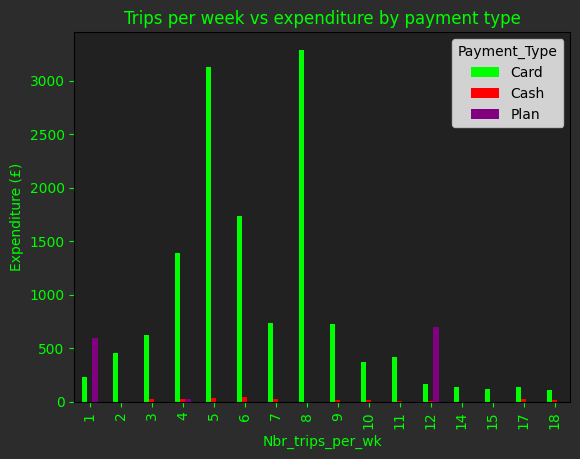

In [51]:
# plotting the above
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

R_P_price.plot(ax=ax,
               kind='bar', 
               ylabel='Expenditure (£)',
               title='Trips per week vs expenditure by payment type', 
               color=['lime','red','purple'])

<h3 style="color: green;">Working with Card_Source</h3>

In [52]:
# counts of Card_Source
cnt_crd = pd.pivot_table(Receipt_Payment, 
               index='Card_Source',
               values='Total_Price',
               aggfunc='count')
cnt_crd

,Total_Price
Card_Source,
0,61
Contactless,626
DB,25
DD,77
Pin,37
Transfer,1


<p style="color: black;">Note Card_source = 0 is payment by cash or plan</p>

<AxesSubplot: title={'center': 'Card source frequency'}, xlabel='Card_Source', ylabel='Frequency'>

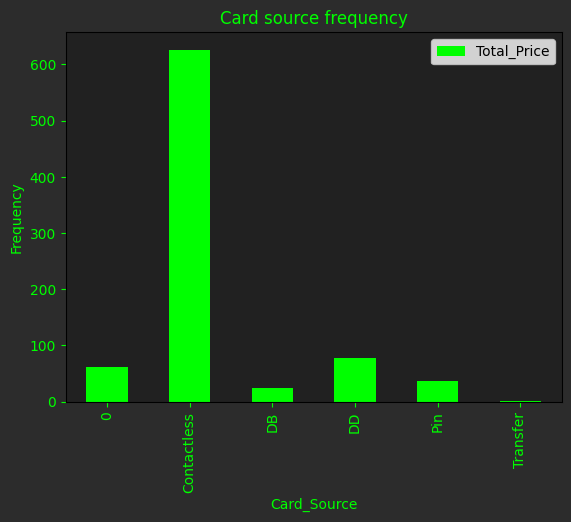

In [53]:
# plotting the above
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

cnt_crd.plot(ax=ax,
               kind='bar', 
               ylabel='Frequency',
               title='Card source frequency', 
               color=['lime'])

In [54]:
# Expenditure by Card_source
Exp_crd = pd.pivot_table(Receipt_Payment, 
               index='Card_Source', 
               values='Total_Price', 
               aggfunc='sum')
Exp_crd

,Total_Price
Card_Source,
0,1570.47
Contactless,5991.11
DB,731.80
DD,2863.20
Pin,2882.90
Transfer,1303.40


<AxesSubplot: title={'center': 'Expenditure by card source'}, xlabel='Card source', ylabel='Expenditure (£)'>

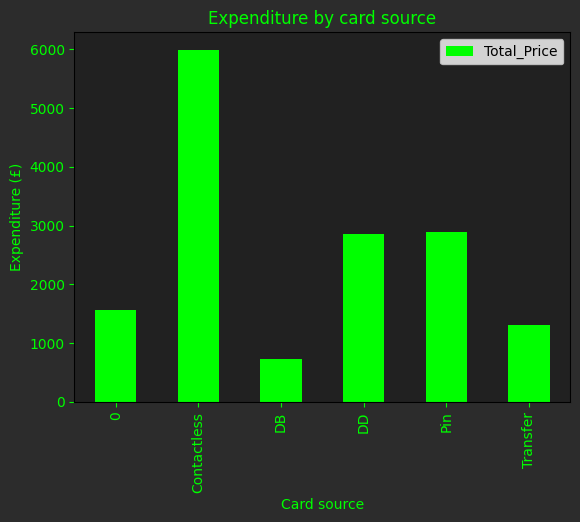

In [55]:

# Plotting the above for visual illustration
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

Exp_crd.plot(ax=ax,
               kind='bar', 
               ylabel='Expenditure (£)',
               xlabel='Card source',
               title='Expenditure by card source',
               color='lime'
            )

In [56]:
# Number of items bought by Card_source
item_crd = pd.pivot_table(Receipt_Payment, 
               index='Card_Source', 
               values='Total_Nbr_of_Items', 
               aggfunc='sum')
item_crd

,Total_Nbr_of_Items
Card_Source,
0,151
Contactless,4276
DB,33
DD,84
Pin,199
Transfer,1


<AxesSubplot: title={'center': 'Items frequency by card source'}, xlabel='Card source', ylabel='Nbr of items'>

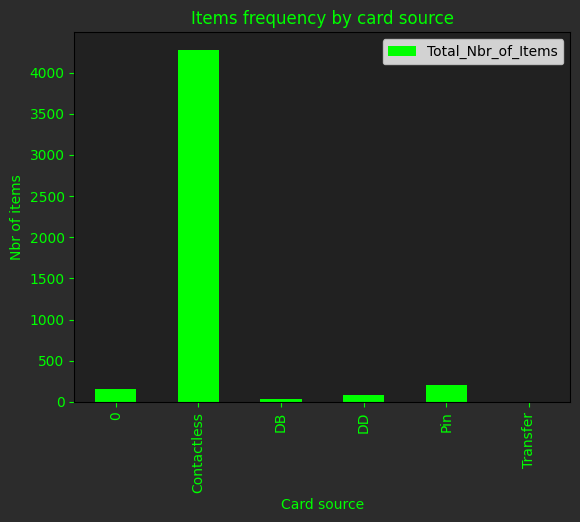

In [57]:
# Plotting the above for visual illustrations
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

item_crd.plot(ax=ax,
               kind='bar', 
               ylabel='Nbr of items',
               xlabel='Card source',
               title='Items frequency by card source',
               color='lime'
            )

<h3 style="color: green;">Checks on card source with number of trips per week vs total number of items or item price</h3>

<p style="color: black;">Frequencies of Nbr_trips_per_wk vs Total_Nbr_of_Items by card source</p>

In [58]:
R_P_source = pd.pivot_table(Receipt_Payment, 
                            index='Nbr_trips_per_wk',
                            columns='Card_Source', 
                            values='Total_Nbr_of_Items', 
                            aggfunc='sum').fillna(0)
R_P_source

Card_Source,0,Contactless,DB,DD,Pin,Transfer
Nbr_trips_per_wk,,,,,,
1,2.0,53.0,5.0,1.0,0.0,0.0
2,0.0,296.0,3.0,3.0,19.0,0.0
3,30.0,382.0,1.0,14.0,0.0,0.0
4,15.0,671.0,5.0,11.0,2.0,0.0
5,16.0,966.0,4.0,16.0,80.0,0.0
6,37.0,718.0,0.0,15.0,26.0,0.0
7,14.0,256.0,0.0,3.0,25.0,0.0
8,0.0,242.0,4.0,7.0,1.0,1.0
9,7.0,252.0,9.0,3.0,29.0,0.0


<AxesSubplot: title={'center': 'Trips per week vs items bought by card source'}, xlabel='Nbr_trips_per_wk', ylabel='Item frequencies'>

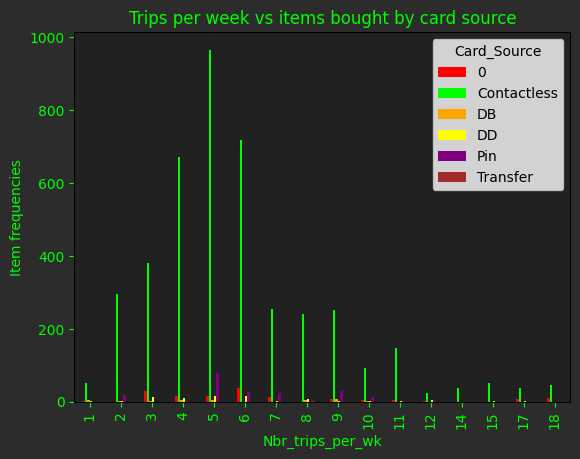

In [59]:
# plotting the above for visual illustration
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

R_P_source.plot(ax=ax,
                kind='bar', 
                ylabel='Item frequencies',
                title='Trips per week vs items bought by card source', 
                color=['red','lime','orange','yellow','purple','brown','blue'])

<p style="color: black;">Frequencies of Nbr_trips_per_wk vs Total_Price by card source</p>

In [60]:
R_P_source_price = pd.pivot_table(Receipt_Payment, 
                            index='Nbr_trips_per_wk',
                            columns='Card_Source', 
                            values='Total_Price', 
                            aggfunc='sum').fillna(0)
R_P_source_price

Card_Source,0,Contactless,DB,DD,Pin,Transfer
Nbr_trips_per_wk,,,,,,
1,598.99,58.61,164.95,9.98,0.00,0.0
2,0.00,301.66,24.99,104.97,20.15,0.0
3,24.35,363.09,10.00,252.76,0.00,0.0
4,55.11,811.13,80.33,454.23,42.00,0.0
5,33.30,1306.84,65.90,983.82,771.47,0.0
6,43.83,1157.03,0.00,441.90,136.70,0.0
7,27.06,355.31,0.00,121.18,255.98,0.0
8,0.00,342.07,221.92,120.95,1299.00,1303.4
9,20.79,315.15,115.91,188.98,104.48,0.0


<AxesSubplot: title={'center': 'Trips per week vs expenditure by card source'}, xlabel='Nbr_trips_per_wk', ylabel='Expenditure (£)'>

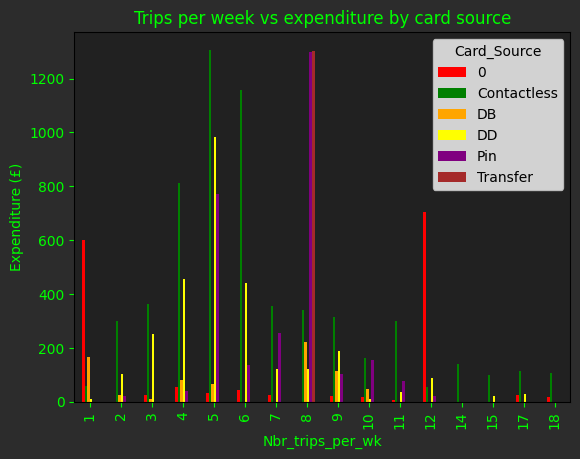

In [61]:
# plotting the above for visual illustration
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')


R_P_source_price.plot(ax=ax,
                      kind='bar', 
                ylabel='Expenditure (£)',
                title='Trips per week vs expenditure by card source', 
                color=['red','green','orange','yellow','purple','brown','blue'])

<ul style="color: black;">
<b style="color: green;">To conclude the section on payment methods:</b>
<li>I shop mainly by card</li>
<li>My prefered method of payment is contactless</li>
<li>In the odd occasion I make big purchases that require a different method e.g. transfer or pin</li>
<li>After contactless, my second preference is to pay by cash. We will find out later as to why</li>
</ul>

<h1 style="color: green;">Exploring shopping item data</h1>

In [62]:
# Reading item table
Item = pd.read_sql_table("item", engine)
Item.tail()

,Item_id,Venue_id,Receipt_id,Venue_Item_code,Item_name,Item_Price,Date_Added
4792,4853,36,852,0,Vimto,2.50,2023-03-16 09:33:33
4793,4854,36,852,0,Digestive chocolate,0.65,2023-03-16 09:33:33
4794,4855,36,852,0,Digestive,0.85,2023-03-16 09:33:33
4795,4856,6,853,0,Black T-shirt,2.50,2023-03-16 19:00:07
4796,4857,15,854,0,Shoes,40.00,2023-03-16 19:02:55


In [63]:
# excluding refunds
print("Item shape with refunds: {}".format(Item.shape))
Item = Item.query("Item_Price > 0")
print("Item shape without refunds: {}".format(Item.shape))

Item shape with refunds: (4797, 7)
Item shape without refunds: (4775, 7)


<p style="color: black;">merging Item to Receipt_Payment for the analysis</p>

In [64]:
raw0 = pd.merge(Receipt_Payment,
                     Item[['Receipt_id','Item_id','Item_name','Item_Price']], 
                     on='Receipt_id', 
                     how='left' )


In [65]:
raw0.tail()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,...,Trips_response_lt_4,Trips_response_lt_5,Trips_response_lt_6,hour,Part_of_day,Payment_Type,Card_Source,Item_id,Item_name,Item_Price
4770,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33,...,0,0,1,11,Morning,Card,Contactless,4853,Vimto,2.50
4771,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33,...,0,0,1,11,Morning,Card,Contactless,4854,Digestive chocolate,0.65
4772,852,36,13,14.81,15032023112526,0,0,2023-03-15,11:25:26,2023-03-16 09:33:33,...,0,0,1,11,Morning,Card,Contactless,4855,Digestive,0.85
4773,853,6,1,2.50,16032023164200,0,0,2023-03-16,16:42:00,2023-03-16 19:00:07,...,0,0,1,16,Afternoon,Card,Contactless,4856,Black T-shirt,2.50
4774,854,15,1,40.00,16032023171027,0,0,2023-03-16,17:10:27,2023-03-16 19:02:55,...,0,0,1,17,Afternoon,Card,Pin,4857,Shoes,40.00


<p style="color: black;">Investigating cash payments</p>

In [66]:
raw0[['Venue','Item_name','Item_Price','Payment_Type','Card_Source']]\
            .query("Card_Source=='0'").tail(60)

,Venue,Item_name,Item_Price,Payment_Type,Card_Source
1628,Yours Supermarket,Original Pineapple 1.4 L,1.69,Cash,0
1796,Sainsbury,Water 4X2L,1.50,Cash,0
1797,Sainsbury,Orange Juice 1l Hubbards,0.59,Cash,0
2325,Maryland,3 Piece chicken Meal,4.49,Cash,0
2335,Yours Supermarket,Yaadgar Fairy cakes,1.49,Cash,0
2352,Yours Supermarket,Elite Kitchen Foil E450,0.99,Cash,0
2353,Yours Supermarket,Yaadgar Fairy cakes,1.49,Cash,0
2366,Yours Supermarket,Yaadgar Fairy cakes,1.49,Cash,0
2490,Maryland,3 Piece chicken Meal,4.49,Cash,0
2491,Yours Supermarket,Rubicon mango 1 ltr,1.19,Cash,0


<ul style="color: black;">
<li>Maryland only takes cash payments</li>
<li>Sam's news charges for using card below 5 pounds</li>
<li>Skylink, bus transport, doesn't neccessarily require cash payments<br>but I prefer to pay
bus fare by cash</li>
<li>The laundrette I use only takes cash payments, I tend to get cash<br>
before buying washing powder or get cash refund from Sainsburys<br>before washing clothes<br>
This might leave me with a few pound coins, that I need to get rid of somhow</li>
<li>Note: the laundrette is not in the database as they don't provide receipts</li>
</ul>
<p style="color: black;"><b>
So to shop at these venues, I mainly use cash. However, there are a few occurrences of cash <br> expenditure at the likes of Aldi and europe; these are rare instances where I am carrying cash.</b>
</p>


<p style="color: black;">Trips, item frequencies and expenditure by Venue</p>

<AxesSubplot: title={'center': 'Number of trips by Venue:\n15 largest frequencies'}, ylabel='Venue'>

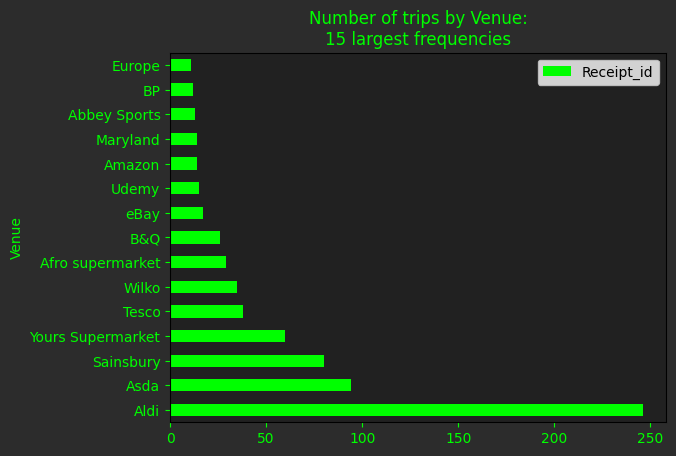

In [67]:
# Trips by venue
Trips_by_venue = pd.pivot_table(raw0, 
                                index='Venue', 
                                values='Receipt_id',
                                aggfunc=lambda x: len(x.unique()))
# plotting the Trips_by_venue
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

Trips_by_venue.nlargest(15,
                        columns='Receipt_id').plot(ax=ax,
                                                    kind='barh', 
                                                    color='lime',
                                                    title=\
                                                   'Number of trips by Venue:\n15 largest frequencies')

In [68]:
# pivot table of number of items by Venue
Freq_by_venue = pd.pivot_table(raw0, index='Venue', values='Receipt_id',aggfunc='count')
Freq_by_venue.head()

,Receipt_id
Venue,
Abbey Sports,13
Afro supermarket,122
Aldi,2550
Amazon,17
Angies Fish Bar,5


<AxesSubplot: title={'center': 'Number of items by Venue:\n8 largest frequencies'}, ylabel='Venue'>

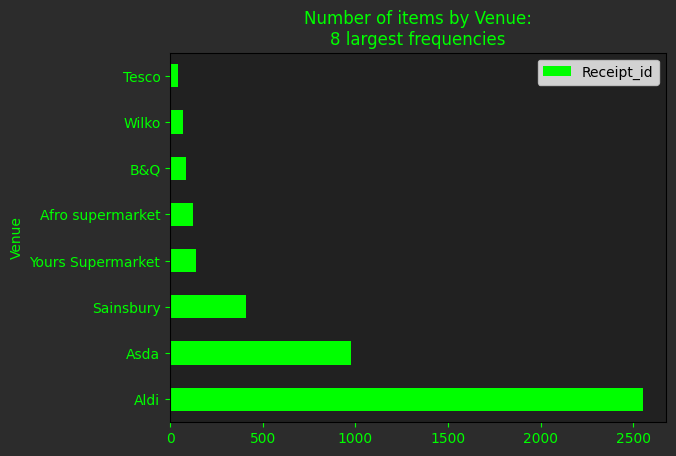

In [69]:
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

# plotting the 8 largest frequencies by venue
Freq_by_venue.nlargest(8,columns='Receipt_id').\
            plot(ax=ax,
                kind='barh', 
                color='lime',
                title='Number of items by Venue:\n8 largest frequencies'
                )

In [70]:
# Pivot table of expenditure by venue
# note, the expenditure here excludes the refunds
expenditure_by_venue = pd.pivot_table(raw0,
                                      index='Venue', 
                                      values='Item_Price', 
                                      aggfunc='sum')
expenditure_by_venue.head(10)

,Item_Price
Venue,
Abbey Sports,378.89
Afro supermarket,248.24
Aldi,2354.96
Amazon,1350.87
Angies Fish Bar,8.80
Apple,1299.00
Asda,1218.49
B&M,1.00
B&Q,450.83


<AxesSubplot: title={'center': 'Expenditure by Venue: \n 15 largest expenditures'}, ylabel='Venue'>

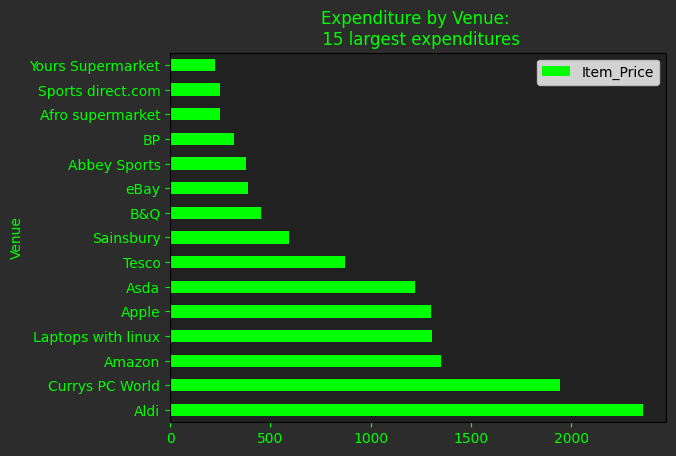

In [71]:
# plotting the above
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')
expenditure_by_venue.nlargest(15,columns='Item_Price').\
        plot(ax=ax,
            kind='barh',
            color='lime',
            title='Expenditure by Venue: \n 15 largest expenditures')

<h3 style="color: green;">Consumption habbits</h3>

<AxesSubplot: title={'center': 'Consumption habbit:\nfrequencies by brand item'}>

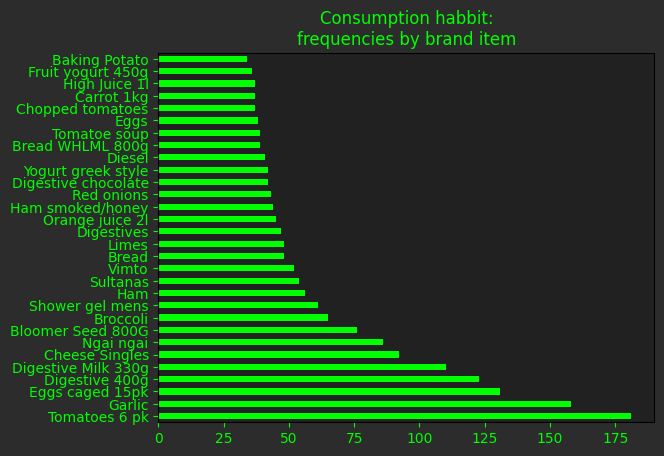

In [72]:
# Retrieving which items i buy the most
consumption = raw0.Item_name.value_counts()

# plotting
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')
consumption.nlargest(30).plot(ax=ax,
                              kind='barh', 
                              color='lime',
                              title='Consumption habbit:\nfrequencies by brand item')

<p style="color: black;">
The bar graph of consumption habbits show the brand items I purchase the most.<br>
Note, this shows a general picture not a precise picture of the items I purchase:<br>
It can be seen that the top purchase is Tomatoes 6 pk but further up the chart<br>
there is Tomatoes 6pack which is the same item. The same can be said for other items<br>
such as digestives, bread brands, carrots etc.<br>
The problem here is how the data was entered in the database; often using what it says<br>
on the receipt.<br><br>
The grouping of items below will offer a deep dive into product groups<br>
which will be used for analysis.
</p>

<h3 style="color: green;">Grouping items and creating new features</h3>

In [73]:
# breads
nots = ['garlic','Ham','Garlic','ham']
ins = ['Bread','bloomer','bread','Bloomer']

raw0['Bread'] = raw0.Item_name.apply(lambda sentence: 1 if any(word in sentence for word in ins) 
                            and not any(word in sentence for word in nots) else 0)

In [74]:
# Check that the bread indicator output
raw0[['Item_name','Item_Price','Bread']].query("Bread == 1").head()

,Item_name,Item_Price,Bread
28,Bloomer Seed 800G,0.99,1
38,Bloomer Seed 800G,0.99,1
59,Bloomer Seed 800G,0.99,1
61,Bloomer Seed 800G,0.99,1
78,Bloomer Seed 800G,0.99,1


In [75]:
# Cooked meats indicator
not_cook = ['glass','shampoo','water','conditioner','champagne']
cooked_meats = ['chicken pasty Slices twin pack','steak and kidney pasty',
                'chicken cooked','cooked chicken','roast chicken thighs',
                'mackerel','Salmon','pork pies classic','ham',
                'sardines','sausages cocktail','spicy chorizo sausages',
                'sausages rolls','sausage rolls','salami','meatballs']

raw0['Cooked_meats'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                            any(word.lower() in sentence.lower() 
                                                for word in cooked_meats) 
                                            and not any(word.lower() in sentence.lower() 
                                                        for word in not_cook) 
                                            else 0)

In [76]:
# Checking that the cooked meats indicator was created correctly
raw0[['Item_name','Item_Price','Cooked_meats']].query("Cooked_meats==1").tail()

,Item_name,Item_Price,Cooked_meats
4683,Ham,1.69,1
4708,Ham,1.69,1
4735,Ham,1.69,1
4746,Ham,1.69,1
4760,Ham,1.69,1


In [77]:
# Raw meats indicator
not_raw = ['pasty','cooked','roast','seasoning',
           'southern','fried','meal','piece',
           'box','bake','szechuan','pies',
           'mushroom','pie','salami','rolls','cocktails',
           'chips','chorizo']
raw_meats = ['bacon','chicken','lamb','gammon','sausages',
             'sausage','pork','fish','beef','eggs']

raw0['Raw_meats'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower() for word in raw_meats) 
                            and not any(word.lower() in sentence.lower() for word in not_raw) else 0)


In [78]:
raw0[['Item_name','Item_Price','Raw_meats']].query("Raw_meats==1").tail()

,Item_name,Item_Price,Raw_meats
4726,Chicken thighs,2.74,1
4727,Chicken thighs,2.74,1
4738,Eggs,3.50,1
4761,Pork chops,3.19,1
4764,Corned beef,1.90,1


In [79]:
# Creating eating out indicator using the restaurants and fastfoods Venue id
eating_out = [11,20,25,31,34,35,40,41,42,48]
raw0['Eating_out'] = raw0.apply(lambda x: 1 if x['Venue_id'] in eating_out or 
                                         x['Item_name'] in ['Food @ space centre',
                                                         'Drinks @ space centre'] 
                                         else 0,axis=1)

In [80]:
raw0[['Venue','Item_name','Item_Price','Eating_out']].query("Eating_out==1").tail()

,Venue,Item_name,Item_Price,Eating_out
4423,KFC,Bargain bucket: 14 pc,21.99,1
4424,KFC,4 mini fillets,4.00,1
4425,KFC,Tango 1.5 l bottle,2.79,1
4426,KFC,Oreo biscuit krushems,2.39,1
4427,KFC,Oreo biscuit krushems,2.39,1


In [81]:
# Creating snack indicator
not_snack = ['diesel','james']
snacks = ['snickers','digestive','digestives',
          'chocolate','yogurt','cake','cakes',
          'snack','nuts','donuts','doughnut',
          'mikati','fudge','maltesers','twix','marmalade',
          'jam','custard']

raw0['Snacks'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                      any(word.lower() in sentence.lower() for word in snacks)
                                      and not 
                                      any(word.lower() in sentence.lower() for word in not_snack)
                                     else 0)


In [82]:
raw0[['Item_name','Item_Price','Snacks']].query("Snacks==1").tail()

,Item_name,Item_Price,Snacks
4748,Digestive chocolate,0.65,1
4749,Digestive,0.85,1
4755,Digestive chocolate,0.65,1
4771,Digestive chocolate,0.65,1
4772,Digestive,0.85,1


In [83]:
# Creating drinks indicator variable
# Note: this includes alcoholic and non alcoholic drinks

not_drink = ['diesel','glass','socks','fan','heater',
             'beef','source','ironing','plaster','ham','lockets']

drinks = ['juice','vimto','ribena','squash','tropical','liquer',
          'dr pepper','coke','alcohol','beer','rubicon','courvoisier'
          'wine','irish','port','rum','original','smoothies','water',
          'honey','cordial','whiskey','whisky']

raw0['Drinks'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower()
                                                                for word in drinks) 
                                      and not any(word.lower() in sentence.lower() 
                                                  for word in not_drink)
                                     else 0)

In [84]:
raw0[['Item_name','Item_Price','Drinks']].query("Drinks==1").tail()

,Item_name,Item_Price,Drinks
4691,Vimto,3.0,1
4724,Vimto,3.0,1
4753,Southern comfort whisky,14.0,1
4759,Fruit juice,1.8,1
4770,Vimto,2.5,1


In [85]:
# Creating a vegetables indicator
not_veg = ['seed','bread','fried','black','dr','lisbon']
vegetables = ['cabbage','carrots','parsnip','greens','garlic','ginger',
              'tomatoes','onions','chillies','ngai ngai','leaf',
              'leaves','mushrooms','spinach','coriander','parsley',
              'broccoli','pumpkin','peas','peppers','cucumber','leeks',
             'brussel sprouts','mint','asparagus','beans','Soup']

raw0['Vegetables'] = raw0.Item_name.apply(lambda sentence: 
                                          1 if any(word.lower() in sentence.lower() 
                                                   for word in vegetables)
                                         and not any(word.lower() in sentence.lower() 
                                                     for word in not_veg)
                                         else 0)

In [86]:
raw0[['Item_name','Item_Price','Vegetables']].query("Vegetables==1").head()

,Item_name,Item_Price,Vegetables
45,Parsnips 500g,0.57,1
47,Baby spinach,0.99,1
48,Baby spinach,0.99,1
52,Coriander cut,0.39,1
53,Coriander cut,0.39,1


In [87]:
# Creating a fruits indicator
not_fruit = ['juice','rubicon','original','smoothies','yogurt','cordial',
             'ribena','squash','volvic','water','lockets','bucket']
fruit = ['olives','apples','mango','grape','grapes','bananas',
          'lime','lemon','strawberries','oranges']

raw0['Fruit'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower() 
                                                               for word in fruit) 
                                     and not any(word.lower() in sentence.lower() 
                                                 for word in not_fruit)
                                    else 0)

In [88]:
raw0[['Item_name','Item_Price','Fruit']].query("Fruit==1").tail()

,Item_name,Item_Price,Fruit
4712,Bananas,1.24,1
4713,Loose mango,0.90,1
4750,Loose mango,1.69,1
4751,Loose mango,1.69,1
4752,Loose mango,1.69,1


In [89]:
# Creating an indicator for cooking base
not_base = ['fried']
cooking_base = ['pasta','spaghetti','rice','flour','potatoe','potatoes','potato']

raw0['Cooking_base'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                            any(word.lower() in sentence.lower() 
                                                for word in cooking_base) 
                                            and not any(word.lower() in sentence.lower() 
                                                        for word in not_base) 
                                            else 0)

In [90]:
raw0[['Item_name','Item_Price','Cooking_base']].query("Cooking_base==1").tail()

,Item_name,Item_Price,Cooking_base
3993,Baking potato,0.31,1
4065,Easy cook rice 10kg,10.49,1
4152,Potato,0.15,1
4207,Loose potatoe,0.15,1
4412,Potatoes,0.22,1


In [91]:
# Creating an indicator for Dairy produce
dairy_produce = ['cheese','brilliantly','butter','butterlicious','spread','margarine']
raw0['Dairy_produce'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                             any(word.lower() in sentence.lower() 
                                                 for word in dairy_produce) 
                                             else 0)

In [92]:
raw0[['Item_name','Item_Price','Dairy_produce']].query("Dairy_produce==1").tail()

,Item_name,Item_Price,Dairy_produce
4624,Cheese spread,1.25,1
4672,Cheese spread,1.25,1
4684,Cheese spread,1.25,1
4709,Cheese spread,1.25,1
4747,Cheese spread,1.25,1


In [93]:
# Creating an indicator for seasoning
seasoning = ['black pepper','salt','seasoning','spice','cinnamon','paprika']

raw0['Seasoning'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in seasoning) 
                                         else 0 )

In [94]:
raw0[['Item_name','Item_Price','Seasoning']].query("Seasoning==1").tail()

,Item_name,Item_Price,Seasoning
4040,Table salt,0.55,1
4041,Table salt,0.55,1
4343,EE Jerk seasoning,0.59,1
4344,EE Jerk seasoning,0.59,1
4345,EE Jerk seasoning,0.59,1


In [95]:
# creating an indicator for breakfast food
breakfast = ['granola','muesli','sultanas','Porridge']

raw0['Breakfast'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in breakfast) 
                                         else 0 )

In [96]:
raw0[['Receipt_id','Venue','Item_name','Item_Price','Breakfast']].query("Breakfast==1")

,Receipt_id,Venue,Item_name,Item_Price,Breakfast
779,114,Aldi,Muesli swiss,1.69,1
812,116,Aldi,Muesli swiss,1.69,1
853,124,Aldi,Muesli swiss,1.69,1
968,154,Aldi,Muesli swiss,1.69,1
1233,183,Aldi,Muesli swiss,1.69,1
...,...,...,...,...,...
4717,845,Asda,Porridge,0.70,1
4718,845,Asda,Porridge,0.70,1
4719,845,Asda,Sultanas,0.95,1
4720,845,Asda,Sultanas,0.95,1


In [97]:
raw0[['Item_name','Item_Price','Breakfast']].query("Breakfast==1").tail()

,Item_name,Item_Price,Breakfast
4717,Porridge,0.70,1
4718,Porridge,0.70,1
4719,Sultanas,0.95,1
4720,Sultanas,0.95,1
4721,Sultanas,0.95,1


In [98]:
# Creating an indicator for transport
transport = ['unleaded','diesel','return ticket']
raw0['Transport'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in transport)
                                         else 0)

In [99]:
raw0[['Item_name','Item_Price','Transport']].query("Transport==1").tail()

,Item_name,Item_Price,Transport
4418,Diesel 7.99l @ £1.879/l,15.01,1
4419,Diesel 16.96 @ £1.769/l,30.00,1
4420,Diesel 13.16l @ £1.999/l,26.31,1
4428,Victoria station return ticket,37.80,1
4678,Return ticket,4.00,1


In [100]:
# Creating an indicator for diy
not_diy = ['sony']
diy = ['fifty box 44l black','soil scoop','garden glove','compost','carrot amsterdam',
       'cabbage copenhagen','parsnip gladiator','Spring onion white lisbon seed','bucket',
       'onion white ailsa craig seed','dahlia assorted bright seed','gorilla',
       'kaze box','galvanised garden wheelbarrow','magnusson 500mm steel ruler',
       'tape measure','timber','bosch 34 piece drill accessory','wood screw steel',
       'bolted screws set','decking srew csk pz pk500','heavy duty rubble sacks 50l',
       'magnusson screw driver slot 100 x','wiha slotted screw driver 150 x',
       'general purpose plier set 3pc','mag ratchet precision Screwdriver',
       'diall l75 decking screws 250pck','chrome plated barrel latch','wire',
       'satin nickel barrel latch','chrome plated barrel latch',
       'ronseal varnish outdoor clear gloss','zipper metal silver teeth',
       'neodymium magnets']

raw0['DIY'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower() 
                                                             for word in diy) 
                                   and not any(word.lower() in sentence.lower() 
                                               for word in not_diy) 
                                   else 0)

In [101]:
raw0[['Item_name','Item_Price','DIY']].query("DIY==1").tail()

,Item_name,Item_Price,DIY
3477,Heavy duty rubble sacks 50l,7.30,1
3491,Ronseal varnish outdoor clear gloss,8.00,1
3978,FINDMAG 20pack Neodymium magnets,19.99,1
4367,Gorilla glue,9.98,1
4423,Bargain bucket: 14 pc,21.99,1


In [102]:
# Creating an indicator for electronics
electronics = ['macallister combi drill','macallister multipendulum jigsaw 600w',
               'bench table saw','fan heater','voltmeter','hair clippers wahl',
               'silk steamer','vacuum cleaner','table saw',
               'rotary tool kit','reciprocating saws','air fryer oven']

raw0['Electronics'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                           any(word.lower() in sentence.lower() 
                                               for word in electronics) 
                                           else 0)

In [103]:
raw0[['Item_name','Item_Price','Electronics']].query("Electronics ==1").tail()

,Item_name,Item_Price,Electronics
1343,TACKLIFE 135W Rotary Tool Kit,23.99,1
2476,Hoover Whirlwind Bagless Cylinder Vacuum Cleaner,69.00,1
2477,"GALAX PRO Reciprocating Saws 20V,",65.99,1
2525,Air fryer oven (23l),129.99,1
3449,Macallister multipendulum jigsaw 600w,25.00,1


In [104]:
# creating an indicator for education
not_edu = ['clevo']
education = ['King Richard Williams','linkedin','mysql','financial','python',
             'bootcamp','web server','linux','apache','sas','pencils',
             'eraser','WHS 15cm ruler','bic pen','a4','binders']

raw0['Education'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in education) 
                                         and not 
                                         any(word.lower() in sentence.lower() 
                                             for word in not_edu) 
                                         else 0)

In [105]:
raw0[['Item_name','Item_Price','Education']].query("Education==1").tail()

,Item_name,Item_Price,Education
3932,LinkedIn premium membership,53.99,1
4177,LinkedIn premium membership,29.99,1
4291,LinkedIn Premium membership,29.99,1
4348,Python django 4 Masterclass,12.99,1
4422,Kansas bbq dipped bites,2.49,1


In [106]:
# Creating an indicator for tech and services
tech_and_services = ['macbook pro','flash drive','lonovo','sony','clevo','tesco','domain registration',
                     'membership payment','Headphones']

raw0['Tech_and_services'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in tech_and_services) 
                                                 else 0)

In [107]:
raw0[['Item_name','Item_Price','Tech_and_services']].query("Tech_and_services==1").tail()

,Item_name,Item_Price,Tech_and_services
4317,Tesco mobile new Iphone & contract,48.99,1
4452,Tesco mobile new Iphone & contract,48.99,1
4567,Tesco mobile new Iphone & contract,48.99,1
4700,Tesco mobile new Iphone & contract,48.99,1
4758,Headphones,7.99,1


In [108]:
# Creating an indicator for cosmetics and self care

not_cosmetic = ['sony']
cosmetics_and_selfcare = ['shampoo','shower','tooth','colgate','wisdom','nivea',
                          'razor','body','blades','aqueous','shave','african',
                          'perfume','brut','roll on','Roll-on','bettina bath']

raw0['Cosmetics_and_selfcare'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                      any(word.lower() in sentence.lower() 
                                                          for word in cosmetics_and_selfcare) 
                                                      and not 
                                                      any(word.lower() in sentence.lower() 
                                                          for word in not_cosmetic) 
                                                      else 0)

In [109]:
raw0[['Item_name','Item_Price',
      'Cosmetics_and_selfcare']].query("Cosmetics_and_selfcare == 1").tail()

,Item_name,Item_Price,Cosmetics_and_selfcare
4628,Shower gel,1.9,1
4645,Toothbrush,1.5,1
4716,Nivea shaving gel,2.7,1
4756,Toothpaste,2.0,1
4757,Shower gel,1.9,1


In [110]:
# Creating an indicator for clothes and shoes
clothes_and_shoes = ['lonsdale','slaz','trainers','addidas','puma','sondico','nike',
                     'umbrella','trousers','socks','shirt','boxers','gloves','boots',
                     'insoles']
raw0['Clothes_and_shoes'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in clothes_and_shoes) 
                                                 else 0)

In [111]:
raw0[['Item_name','Item_Price','Clothes_and_shoes']].query("Clothes_and_shoes==1").tail()

,Item_name,Item_Price,Clothes_and_shoes
4179,Slazenger jogging bottoms,8.5,1
4180,Slazenger jogging bottoms,8.5,1
4302,Umbrella,5.0,1
4413,Stag socks 5 pack,14.0,1
4773,Black T-shirt,2.5,1


In [112]:
# creating an indicator for house and kitchen 
not_house = ['cake']
house_and_kitchen = ['fairy liquid','measure jug','fitted bed sheet','glass',
                     'turner (spatula)','rolling pin','fairy liquid','orange citrus',
                     'turkey baster','dish drainer','extension lead','grater','power spray',
                     'liquid','roaster and rack','kitchen roller','salad tongs',
                     'strainer 12cm','arial pods','metal scourer','bathmat','curtain hooks',
                     'ant killer spray','scouring pads','sponge','surf','foil','plaster',
                     'knife sharpener','electric hand mixer','athena cotton wool','mop',
                     'ofargo']

raw0['House_and_kitchen'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in house_and_kitchen) 
                                                 and not 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in not_house) 
                                                 else 0)

In [113]:
raw0[['Item_name','Item_Price','House_and_kitchen']].query("House_and_kitchen==1").tail()

,Item_name,Item_Price,House_and_kitchen
4146,Aluminium foil,0.68,1
4399,Surf washing powder,5.80,1
4545,Washing up liquid,3.00,1
4546,Scouring pads,1.60,1
4634,Extension lead black,11.00,1


<p style="color: black;">Aggregating the indicators by Receipt_id</p>

In [114]:
indicator_list = ['Bread','Cooked_meats','Raw_meats','Eating_out','Snacks','Drinks',
                  'Vegetables','Fruit','Cooking_base','Dairy_produce','Seasoning',
                  'Breakfast','Transport','DIY','Electronics','Education',
                  'Tech_and_services','Cosmetics_and_selfcare','Clothes_and_shoes',
                  'House_and_kitchen']

# Looping through the indicator list to derive new features
for x in indicator_list:
    # Calculate item x count by shopping trip(Receipt) and by week
    raw0["{}_receipt".format(x)] = raw0.groupby(['Receipt_id'])[x].transform('sum')
    raw0["{}_wk".format(x)] = raw0.groupby(['week_of_year'])[x].transform('sum')

    # Receipt item x as a proportion of week's item x
    raw0["{}_wk_perc".format(x)] = raw0["{}_receipt".format(x)] / raw0["{}_wk".format(x)]

    # Calculating item x expenditure by shopping trip(Receipt) and by week
    raw0["{}_exp_receipt".format(x)] = \
    raw0.query("{}==1".format(x)).groupby(['Receipt_id',x])['Item_Price'].transform('sum')
    
    raw0["{}_exp_wk".format(x)] = \
    raw0.query("{}==1".format(x)).groupby(['week_of_year',x])['Item_Price'].transform('sum')
    
    # Receipt item x expenditure as a proportion of week's item x expenditure
    raw0["{}_wk_exp_perc".format(x)] = \
    raw0["{}_exp_receipt".format(x)] / raw0["{}_exp_wk".format(x)]

In [115]:
# Checking that the for loop above worked correctly
# print(raw0.shape)
# raw0.iloc[2000:2060,43:]

In [116]:
# printing all the features prior to restricting to analysis data
x =  raw0.columns
x[:60]

Index(['Receipt_id', 'Venue_id', 'Total_Nbr_of_Items', 'Total_Price',
       'Receipt_Nbr', 'Trans_number', 'Barcode', 'Receipt_Date',
       'Receipt_Time', 'Date_Added', 'Venue', 'Date_diff', 'Week_day',
       'Week_day_numeric', 'week_of_year', 'Nbr_trips_per_wk',
       'Nbr_items_per_wk', 'Nbr_items_wk_perc', 'Expenditure_per_wk',
       'Total_Exp_wk_perc', 'Trips_response_lt_4', 'Trips_response_lt_5',
       'Trips_response_lt_6', 'hour', 'Part_of_day', 'Payment_Type',
       'Card_Source', 'Item_id', 'Item_name', 'Item_Price', 'Bread',
       'Cooked_meats', 'Raw_meats', 'Eating_out', 'Snacks', 'Drinks',
       'Vegetables', 'Fruit', 'Cooking_base', 'Dairy_produce', 'Seasoning',
       'Breakfast', 'Transport', 'DIY', 'Electronics', 'Education',
       'Tech_and_services', 'Cosmetics_and_selfcare', 'Clothes_and_shoes',
       'House_and_kitchen', 'Bread_receipt', 'Bread_wk', 'Bread_wk_perc',
       'Bread_exp_receipt', 'Bread_exp_wk', 'Bread_wk_exp_perc',
       'Cooked_meats_

In [117]:
x[61:121]

Index(['Cooked_meats_wk_exp_perc', 'Raw_meats_receipt', 'Raw_meats_wk',
       'Raw_meats_wk_perc', 'Raw_meats_exp_receipt', 'Raw_meats_exp_wk',
       'Raw_meats_wk_exp_perc', 'Eating_out_receipt', 'Eating_out_wk',
       'Eating_out_wk_perc', 'Eating_out_exp_receipt', 'Eating_out_exp_wk',
       'Eating_out_wk_exp_perc', 'Snacks_receipt', 'Snacks_wk',
       'Snacks_wk_perc', 'Snacks_exp_receipt', 'Snacks_exp_wk',
       'Snacks_wk_exp_perc', 'Drinks_receipt', 'Drinks_wk', 'Drinks_wk_perc',
       'Drinks_exp_receipt', 'Drinks_exp_wk', 'Drinks_wk_exp_perc',
       'Vegetables_receipt', 'Vegetables_wk', 'Vegetables_wk_perc',
       'Vegetables_exp_receipt', 'Vegetables_exp_wk', 'Vegetables_wk_exp_perc',
       'Fruit_receipt', 'Fruit_wk', 'Fruit_wk_perc', 'Fruit_exp_receipt',
       'Fruit_exp_wk', 'Fruit_wk_exp_perc', 'Cooking_base_receipt',
       'Cooking_base_wk', 'Cooking_base_wk_perc', 'Cooking_base_exp_receipt',
       'Cooking_base_exp_wk', 'Cooking_base_wk_exp_perc',
       '

In [118]:
x[122:]

Index(['Transport_receipt', 'Transport_wk', 'Transport_wk_perc',
       'Transport_exp_receipt', 'Transport_exp_wk', 'Transport_wk_exp_perc',
       'DIY_receipt', 'DIY_wk', 'DIY_wk_perc', 'DIY_exp_receipt', 'DIY_exp_wk',
       'DIY_wk_exp_perc', 'Electronics_receipt', 'Electronics_wk',
       'Electronics_wk_perc', 'Electronics_exp_receipt', 'Electronics_exp_wk',
       'Electronics_wk_exp_perc', 'Education_receipt', 'Education_wk',
       'Education_wk_perc', 'Education_exp_receipt', 'Education_exp_wk',
       'Education_wk_exp_perc', 'Tech_and_services_receipt',
       'Tech_and_services_wk', 'Tech_and_services_wk_perc',
       'Tech_and_services_exp_receipt', 'Tech_and_services_exp_wk',
       'Tech_and_services_wk_exp_perc', 'Cosmetics_and_selfcare_receipt',
       'Cosmetics_and_selfcare_wk', 'Cosmetics_and_selfcare_wk_perc',
       'Cosmetics_and_selfcare_exp_receipt', 'Cosmetics_and_selfcare_exp_wk',
       'Cosmetics_and_selfcare_wk_exp_perc', 'Clothes_and_shoes_receipt',
   

<h1 style="color: green;">Handling missing values</h1>
<p style="color: black;">
Filling in the missing values at receipt level with the non missing values<br>
for each feature with missing values
</p>

In [119]:
#checking the shape of raw0
raw0.shape

(4775, 170)

In [120]:
# Checking missing values for date related features
raw0[['Date_diff','Week_day','Week_day_numeric','week_of_year']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4774
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date_diff         4774 non-null   float64
 1   Week_day          4775 non-null   object 
 2   Week_day_numeric  4775 non-null   int64  
 3   week_of_year      4775 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 186.5+ KB


In [121]:
# Filling in the single missing value for Date_diff
raw0['Date_diff'].fillna(0,inplace=True)
raw0[['Date_diff','Week_day','Week_day_numeric','week_of_year']].head()

,Date_diff,Week_day,Week_day_numeric,week_of_year
0,0.0,Friday,5,2019_38
1,0.0,Friday,5,2019_38
2,0.0,Friday,5,2019_38
3,5.0,Wednesday,3,2019_39
4,1.0,Thursday,4,2019_39


In [122]:
# Retrieve subsets of the features to get display raw1.info
# x = raw0.columns
# raw0[x[:60]].info()

In [123]:
# Filling in missing values from the check above

# The analysis is done at receipt level, not at item level
# so the summaries of interest are at receipt level
# if at receipt level there is a missing value this value is
# filled by summing over the item level values

# i.e. to get the receipt level data, we will retrieve the first row
# for the respective receipt which would contain only the first item values
# instead we groupby receipt and the feature of interest to get that summary value
# over all receipt item of interest.

# example: Receipt has only 5 tomatoe 6 packs for vegetables
# row 1: 1 tomatoe 6 packs, row 2: 1 tomatoe 6 packs, row 3: 1 tomatoe 6 packs ...
# number of Vegetables_receipt is 5

fill_na_list = ['Bread_wk_perc','Bread_exp_receipt','Bread_exp_wk',
             'Bread_wk_exp_perc','Cooked_meats_receipt','Cooked_meats_wk','Cooked_meats_wk_perc','Cooked_meats_exp_receipt',
             'Cooked_meats_exp_wk','Raw_meats_receipt','Raw_meats_wk','Raw_meats_wk_perc','Raw_meats_exp_receipt',
             'Raw_meats_exp_wk','Raw_meats_wk_exp_perc','Eating_out_receipt','Eating_out_wk','Eating_out_wk_perc',
             'Eating_out_exp_receipt','Eating_out_exp_wk','Eating_out_wk_exp_perc','Snacks_receipt','Snacks_wk',
             'Snacks_wk_perc','Snacks_exp_receipt','Snacks_exp_wk','Snacks_wk_exp_perc','Drinks_receipt','Drinks_wk',
             'Drinks_wk_perc','Drinks_exp_receipt','Drinks_exp_wk','Drinks_wk_exp_perc','Vegetables_receipt',
             'Vegetables_wk','Vegetables_wk_perc','Vegetables_exp_receipt','Vegetables_exp_wk','Vegetables_wk_exp_perc',
             'Fruit_receipt','Fruit_wk','Fruit_wk_perc','Fruit_exp_receipt','Fruit_exp_wk','Fruit_wk_exp_perc',
             'Cooking_base_receipt','Cooking_base_wk','Cooking_base_wk_perc','Cooking_base_exp_receipt','Cooking_base_exp_wk',
             'Cooking_base_wk_exp_perc','Dairy_produce_receipt','Dairy_produce_wk','Dairy_produce_wk_perc',
             'Dairy_produce_exp_receipt','Dairy_produce_exp_wk','Dairy_produce_wk_exp_perc','Seasoning_receipt',
             'Seasoning_wk','Seasoning_wk_perc','Seasoning_exp_receipt','Seasoning_exp_wk','Seasoning_wk_exp_perc',
             'Breakfast_receipt','Breakfast_wk','Breakfast_wk_perc','Breakfast_exp_receipt','Breakfast_exp_wk',
             'Breakfast_wk_exp_perc','Transport_wk','Transport_wk_perc','Transport_exp_receipt','Transport_exp_wk',
             'Transport_wk_exp_perc','DIY_receipt','DIY_wk','DIY_wk_perc','DIY_exp_receipt','DIY_exp_wk','DIY_wk_exp_perc',
             'Electronics_receipt','Electronics_wk','Electronics_wk_perc','Electronics_exp_receipt','Electronics_exp_wk',
             'Electronics_wk_exp_perc','Education_receipt','Education_wk','Education_wk_perc','Education_exp_receipt',
             'Education_exp_wk','Education_wk_exp_perc','Tech_and_services_receipt','Tech_and_services_wk',
             'Tech_and_services_wk_perc','Tech_and_services_exp_receipt','Tech_and_services_exp_wk',
             'Tech_and_services_wk_exp_perc','Cosmetics_and_selfcare_receipt','Cosmetics_and_selfcare_wk',
             'Cosmetics_and_selfcare_wk_perc','Cosmetics_and_selfcare_exp_receipt','Cosmetics_and_selfcare_exp_wk',
             'Cosmetics_and_selfcare_wk_exp_perc','Clothes_and_shoes_receipt','Clothes_and_shoes_wk',
             'Clothes_and_shoes_wk_perc','Clothes_and_shoes_exp_receipt','Clothes_and_shoes_exp_wk',
             'Clothes_and_shoes_wk_exp_perc','House_and_kitchen_receipt','House_and_kitchen_wk',
             'House_and_kitchen_wk_perc','House_and_kitchen_exp_receipt','House_and_kitchen_exp_wk',
             'House_and_kitchen_wk_exp_perc']

for x in fill_na_list:
    y = raw0.groupby(['Receipt_id'])[x].transform('sum')
    raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))
/tmp/ipykernel_6191/1370714011.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x

In [124]:
# Rechecking subsets of the features to get display raw1.info
# x = raw0.columns
# raw0[x[122:]].info()

<h1 style="color: green;">Encoding features manually</h1>

<p style="color: black;">
Manual encoding is being used instead of the LabelEncoder<br>
because I want to know exactly what each encoding means
</p>

In [125]:
# checking the distribution of Part_of_day
raw0.Part_of_day.value_counts()

Afternoon     2314
Morning       1622
Evening        692
Early          107
Late_night      40
Name: Part_of_day, dtype: int64

In [126]:
# Encoding Part_of_day
# Note, this is ordinal so we will not be using label encoder
# as the order of the values is meaningful
raw0['Part_of_day_num'] = raw0['Part_of_day']


encode_Part_of_day = {'Part_of_day_num':{'Early':0,
                                         'Morning':1,
                                         'Afternoon':2,
                                         'Evening':3,
                                         'Late_night':4}}

# Applying the encoder
raw0.replace(encode_Part_of_day, inplace=True)

raw0.Part_of_day_num.value_counts()

/tmp/ipykernel_6191/2002936515.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  raw0['Part_of_day_num'] = raw0['Part_of_day']


2    2314
1    1622
3     692
0     107
4      40
Name: Part_of_day_num, dtype: int64

In [127]:
# Checking the distribution of Payment_Type
raw0.Payment_Type.value_counts()

Card    4625
Cash     146
Plan       4
Name: Payment_Type, dtype: int64

In [128]:
# Encoding Payment_Type using label encoder
enc_Payment_Type = OneHotEncoder()
enc_Payment_Type.fit(raw0[['Payment_Type']])

# Creating the encoded features names list
cols = np.sort(raw0.Payment_Type.unique())

# Transforming/ transposing
encoded_feat_enc_Payment_Type = enc_Payment_Type.transform(raw0[['Payment_Type']]).toarray()

# Adding the transformed features to the dataframe
raw0[cols] = encoded_feat_enc_Payment_Type

In [129]:
raw0.Payment_Type.value_counts()

Card    4625
Cash     146
Plan       4
Name: Payment_Type, dtype: int64

In [130]:
# Checking where Plan==1 to see that the encoding has worked properly
raw0[['Payment_Type','Card','Cash','Plan']].query("Plan==1").head()

,Payment_Type,Card,Cash,Plan
15,Plan,0.0,0.0,1.0
16,Plan,0.0,0.0,1.0
463,Plan,0.0,0.0,1.0
3262,Plan,0.0,0.0,1.0


In [131]:
raw0[['Receipt_id','Payment_Type','Card_Source','Card','Cash','Plan']].query("Plan==1").head()

,Receipt_id,Payment_Type,Card_Source,Card,Cash,Plan
15,110,Plan,0,0.0,0.0,1.0
16,110,Plan,0,0.0,0.0,1.0
463,50,Plan,0,0.0,0.0,1.0
3262,542,Plan,0,0.0,0.0,1.0


In [132]:
# Renaming/prefixing the Payment_type encoded features to remove confusion
# Note Ptype_ stands for Payment type
raw0.rename(columns= {
    'Card': 'Ptype_Card',
    'Cash': 'Ptype_Cash',
    'Plan': 'Ptype_Plan'
    }, inplace=True)

In [133]:
raw0[['Receipt_id','Payment_Type','Card_Source','Ptype_Card','Ptype_Cash','Ptype_Plan']].\
query("Ptype_Plan==1").head()

,Receipt_id,Payment_Type,Card_Source,Ptype_Card,Ptype_Cash,Ptype_Plan
15,110,Plan,0,0.0,0.0,1.0
16,110,Plan,0,0.0,0.0,1.0
463,50,Plan,0,0.0,0.0,1.0
3262,542,Plan,0,0.0,0.0,1.0


In [134]:
# Encoding Payment_Type using label encoder
enc_Card_Card_Source = OneHotEncoder()
enc_Card_Card_Source.fit(raw0[['Card_Source']])

# Creating the encoded features names list
cols = np.sort(raw0.Card_Source.unique())

# Transforming/ transposing
encoded_feat_enc_Card_Source = enc_Card_Card_Source.transform(raw0[['Card_Source']]).toarray()

# Adding the transformed features to the dataframe
raw0[cols] = encoded_feat_enc_Card_Source

In [135]:
raw0[['Payment_Type','Card_Source','Ptype_Card','Ptype_Cash','Ptype_Plan',
      '0','Contactless','DB','DD','Pin','Transfer']].head()

,Payment_Type,Card_Source,Ptype_Card,Ptype_Cash,Ptype_Plan,0,Contactless,DB,DD,Pin,Transfer
0,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Card,DB,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [136]:
# Renaming/prefixing the Payment_type encoded features to remove confusion
# Note SRC_ stands for source
raw0.rename(columns= {
    '0': 'SRC_Cash_or_plan',
    'Contactless': 'SRC_Contactless',
    'DB': 'SRC_DB',
    'DD':'SRC_DD',
    'Pin':'SRC_Pin',
    'Transfer':'SRC_Transfer'
    }, inplace=True)

In [137]:
raw0[['Payment_Type','Card_Source','Ptype_Card','Ptype_Cash','Ptype_Plan',
      'SRC_Cash_or_plan','SRC_Contactless','SRC_DB','SRC_DD','SRC_Pin','SRC_Transfer']].head()

,Payment_Type,Card_Source,Ptype_Card,Ptype_Cash,Ptype_Plan,SRC_Cash_or_plan,SRC_Contactless,SRC_DB,SRC_DD,SRC_Pin,SRC_Transfer
0,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Card,DB,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Card,DD,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [138]:
raw0.Venue.unique()

array(['eBay', 'Abbey Sports', 'Currys PC World', 'Aldi', 'Europe',
       'Udemy', 'Sports direct.com', 'Wilko', 'Primark', 'B&Q', 'Tesco',
       'Stabana', 'Maryland', 'Sams News', 'Superdrug', 'next',
       'EuroGarages', 'BP', 'Afro supermarket', 'Post office', 'Amazon',
       "Domino's Pizza", 'Yours Supermarket', 'Lidl', 'Skylink',
       'Angies Fish Bar', 'Namecheap', 'Sainsbury', 'M and J Congo Shop',
       'National space centre', 'Apple', 'Laptops with linux',
       'Sunnamusk perfume', 'Clintons cards', 'Batter days chippy',
       'Piri piri chicken', 'Gregs', 'Bounce mania', 'KFC',
       'Leicester libraries', 'Mustafa halal', 'Showcase cinemas',
       'Blackbird pharmacy', 'Select Express', 'Grill shack', 'Asda',
       'WHSmith', 'Skunk Anansie', 'O2 Academy', 'Shanghai moon', 'B&M',
       'Millets', 'LinkedIn', 'Petrol station random',
       'Welcome break service', 'National express', 'The moon & Bell',
       'The Griffin', 'Bel foundry', 'Laundrette', 'John

In [139]:
# Renaming Venues in preparation for OneHotEncoder
venue_dict = {'Venue':
              {'eBay':'eBay',
              'Abbey Sports':'Abbey_Sports',
              'Currys PC World':'Currys_PC_World',
              'Aldi':'Aldi',
              'Europe': 'Europe',
              'Udemy':'Udemy',
              'Sports direct.com':'Sports_direct.com',
              'Wilko': 'Wilko',
              'Primark': 'Primark',
              'B&Q':'B_and_Q',
              'Tesco':'Tesco',
              'Stabana':'Stabana',
              'Maryland':'Maryland',
              'Sams News':'Sams_News',
              'Superdrug': 'Superdrug',
              'next':'next',
              'EuroGarages':'EuroGarages',
              'BP':'BP',
              'Afro supermarket':'Afro_supermarket',
              'Post office': 'Post_office',
              'Amazon':'Amazon',
              "Domino's Pizza": "Dominos_Pizza",
              'Yours Supermarket':'Yours_Supermarket',
              'Lidl':'Lidl',
              'Skylink': 'Skylink',
              'Angies Fish Bar': 'Angies_Fish_Bar',
              'Namecheap':'Namecheap',
              'Sainsbury':'Sainsbury',
              'M and J Congo Shop': 'M_and_J_Congo_Shop',
              'National space centre':'National_space_centre',
              'Apple':'Apple',
              'Laptops with linux':'Laptops_with_linux',
              'Batter days chippy':'Batter_days_chippy',
              'Clintons cards':'Clintons_cards',
              'Sunnamusk perfume':'Sunnamusk_perfume',
              'Piri piri chicken': 'Piri_piri_chicken',
              'Gregs':'Gregs',
              'KFC':'KFC',
              'Bounce mania':'Bounce_mania',
              'Leicester libraries':'Leicester_libraries',
              'Mustafa halal': 'Mustafa_halal',
              'Showcase cinemas':'Showcase_cinemas',
              'Blackbird pharmacy':'Blackbird_pharmacy',
              'Select Express':'Select_Express',
              'Grill shack':'Grill_shack',
              'Asda':'Asda',
              'WHSmith':'WHSmith',
              'Skunk Anansie':'Skunk_Anansie',
              'O2 Academy':'O2_Academy',
              'Shanghai moon': 'Shanghai_moon',
              'B&M':'B_and_M',
              'Millets':'Millets',
              'LinkedIn':'LinkedIn',
              'Petrol station random':'Petrol_station_random',
              'Welcome break service':'Welcome_break_service',
               'National express':'National_express',
               'The moon & Bell':'The_moon_and_Bell',
               'The Griffin':'The_Griffin', 
               'Bel foundry':'Bel_foundry', 
               'Laundrette':'Laundrette', 
               'John Lewis':'John_Lewis'              
              }
             }
raw0.replace(venue_dict,inplace=True)
raw0.Venue.unique()

array(['eBay', 'Abbey_Sports', 'Currys_PC_World', 'Aldi', 'Europe',
       'Udemy', 'Sports_direct.com', 'Wilko', 'Primark', 'B_and_Q',
       'Tesco', 'Stabana', 'Maryland', 'Sams_News', 'Superdrug', 'next',
       'EuroGarages', 'BP', 'Afro_supermarket', 'Post_office', 'Amazon',
       'Dominos_Pizza', 'Yours_Supermarket', 'Lidl', 'Skylink',
       'Angies_Fish_Bar', 'Namecheap', 'Sainsbury', 'M_and_J_Congo_Shop',
       'National_space_centre', 'Apple', 'Laptops_with_linux',
       'Sunnamusk_perfume', 'Clintons_cards', 'Batter_days_chippy',
       'Piri_piri_chicken', 'Gregs', 'Bounce_mania', 'KFC',
       'Leicester_libraries', 'Mustafa_halal', 'Showcase_cinemas',
       'Blackbird_pharmacy', 'Select_Express', 'Grill_shack', 'Asda',
       'WHSmith', 'Skunk_Anansie', 'O2_Academy', 'Shanghai_moon',
       'B_and_M', 'Millets', 'LinkedIn', 'Petrol_station_random',
       'Welcome_break_service', 'National_express', 'The_moon_and_Bell',
       'The_Griffin', 'Bel_foundry', 'Laundrett

In [140]:
# Encoding Venue
enc = OneHotEncoder()
enc.fit(raw0[['Venue']])

# Creating the encoded features names list
cols = np.sort(raw0.Venue.unique())

# Transforming/ transposing
encoded_feat = enc.transform(raw0[['Venue']]).toarray()

# Adding the transformed features to the dataframe
raw0[cols] = encoded_feat

In [141]:
raw0[['Venue','Grill_shack']].query("Grill_shack==1").head()


,Venue,Grill_shack
2996,Grill_shack,1.0


<h1 style="color: green;">Restricting the data to Receipt for modeling</h1>
<p style="color: black;">
The model will be ran at Receipt(shopping trip) level data using the summarised indicator<br>
features, payment data in additions to the original Receipt data.
</p>

In [142]:
raw1 = raw0[['Receipt_id','Venue_id','Total_Nbr_of_Items','Total_Price','Date_diff','Week_day_numeric','Nbr_trips_per_wk','Nbr_items_per_wk',
             'Nbr_items_wk_perc','Expenditure_per_wk','Total_Exp_wk_perc','Trips_response_lt_4','Trips_response_lt_5',
             'Trips_response_lt_6','hour','Part_of_day_num','Ptype_Card','Ptype_Cash','Ptype_Plan',
             'SRC_Cash_or_plan','SRC_Contactless','SRC_DB','SRC_DD','SRC_Pin','SRC_Transfer','Bread_receipt','Bread_wk','Bread_wk_perc',
             'Bread_exp_receipt','Bread_exp_wk','Bread_wk_exp_perc','Cooked_meats_receipt','Cooked_meats_wk','Cooked_meats_wk_perc',
             'Cooked_meats_exp_receipt','Cooked_meats_exp_wk','Raw_meats_receipt','Raw_meats_wk','Raw_meats_wk_perc','Raw_meats_exp_receipt',
             'Raw_meats_exp_wk','Raw_meats_wk_exp_perc','Eating_out_receipt','Eating_out_wk','Eating_out_wk_perc','Eating_out_exp_receipt',
             'Eating_out_exp_wk','Eating_out_wk_exp_perc','Snacks_receipt','Snacks_wk','Snacks_wk_perc','Snacks_exp_receipt','Snacks_exp_wk',
             'Snacks_wk_exp_perc','Drinks_receipt','Drinks_wk','Drinks_wk_perc','Drinks_exp_receipt','Drinks_exp_wk','Drinks_wk_exp_perc',
             'Vegetables_receipt','Vegetables_wk','Vegetables_wk_perc','Vegetables_exp_receipt','Vegetables_exp_wk',
             'Vegetables_wk_exp_perc','Fruit_receipt','Fruit_wk','Fruit_wk_perc','Fruit_exp_receipt','Fruit_exp_wk','Fruit_wk_exp_perc',
             'Cooking_base_receipt','Cooking_base_wk','Cooking_base_wk_perc','Cooking_base_exp_receipt','Cooking_base_exp_wk',
             'Cooking_base_wk_exp_perc','Dairy_produce_receipt','Dairy_produce_wk','Dairy_produce_wk_perc',
             'Dairy_produce_exp_receipt','Dairy_produce_exp_wk','Dairy_produce_wk_exp_perc','Seasoning_receipt',
             'Seasoning_wk','Seasoning_wk_perc','Seasoning_exp_receipt','Seasoning_exp_wk','Seasoning_wk_exp_perc',
             'Breakfast_receipt','Breakfast_wk','Breakfast_wk_perc','Breakfast_exp_receipt','Breakfast_exp_wk',
             'Breakfast_wk_exp_perc','Transport_wk','Transport_wk_perc','Transport_exp_receipt','Transport_exp_wk',
             'Transport_wk_exp_perc','DIY_receipt','DIY_wk','DIY_wk_perc','DIY_exp_receipt','DIY_exp_wk','DIY_wk_exp_perc',
             'Electronics_receipt','Electronics_wk','Electronics_wk_perc','Electronics_exp_receipt','Electronics_exp_wk',
             'Electronics_wk_exp_perc','Education_receipt','Education_wk','Education_wk_perc','Education_exp_receipt',
             'Education_exp_wk','Education_wk_exp_perc','Tech_and_services_receipt','Tech_and_services_wk',
             'Tech_and_services_wk_perc','Tech_and_services_exp_receipt','Tech_and_services_exp_wk',
             'Tech_and_services_wk_exp_perc','Cosmetics_and_selfcare_receipt','Cosmetics_and_selfcare_wk',
             'Cosmetics_and_selfcare_wk_perc','Cosmetics_and_selfcare_exp_receipt','Cosmetics_and_selfcare_exp_wk',
             'Cosmetics_and_selfcare_wk_exp_perc','Clothes_and_shoes_receipt','Clothes_and_shoes_wk',
             'Clothes_and_shoes_wk_perc','Clothes_and_shoes_exp_receipt','Clothes_and_shoes_exp_wk',
             'Clothes_and_shoes_wk_exp_perc','House_and_kitchen_receipt','House_and_kitchen_wk',
             'House_and_kitchen_wk_perc','House_and_kitchen_exp_receipt','House_and_kitchen_exp_wk',
             'House_and_kitchen_wk_exp_perc','eBay', 'Abbey_Sports', 'Currys_PC_World', 'Aldi', 'Europe',
             'Udemy', 'Sports_direct.com', 'Wilko', 'Primark', 'B_and_Q','Tesco', 'Stabana', 'Maryland', 
             'Sams_News', 'Superdrug', 'next','EuroGarages', 'BP', 'Afro_supermarket', 'Post_office', 'Amazon',
             'Dominos_Pizza', 'Yours_Supermarket', 'Lidl', 'Skylink','Angies_Fish_Bar', 'Namecheap', 'Sainsbury',
             'M_and_J_Congo_Shop','National_space_centre', 'Apple', 'Laptops_with_linux','Sunnamusk_perfume',
             'Clintons_cards', 'Batter_days_chippy','Piri_piri_chicken', 'Gregs', 'Bounce_mania', 'KFC','Leicester_libraries',
             'Mustafa_halal', 'Showcase_cinemas','Blackbird_pharmacy', 'Select_Express', 'Grill_shack', 'Asda','WHSmith',
             'Skunk_Anansie', 'O2_Academy', 'Shanghai_moon','B_and_M', 'Millets', 'LinkedIn', 'Petrol_station_random',
             'Welcome_break_service', 'National_express', 'The_moon_and_Bell','The_Griffin',
             'Bel_foundry', 'Laundrette', 'John_Lewis']].drop_duplicates(subset=['Receipt_id'])
print(raw1.shape)



(827, 204)


In [143]:
raw1.set_index('Receipt_id',inplace=True)
raw1.sort_values(by='Receipt_id', ascending=True, inplace=True)

<h1 style="color: green;">Checking for seasonalities and trends</h1>

In [144]:
# Subsetting the dataset for better visual display
x = raw1[:300]
x1 = raw1[301:600]
x2 = raw1[601:]

<AxesSubplot: title={'center': 'Expenditure by receipt\nOver time'}, xlabel='Receipt id', ylabel='Price'>

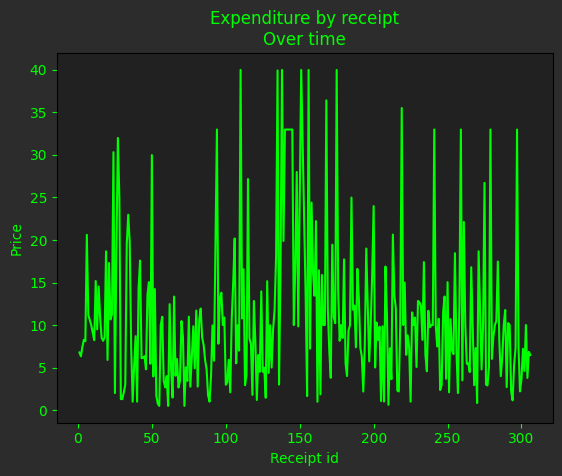

In [166]:
# plotting Total_Price to see if there is seasonality or significant trends
# This will determine whether a time series type of analysis should be employed or not

# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

# raw1.Total_Price[300:400].plot(ax=ax,kind='line',color='lime')
x.Total_Price.plot(ax=ax,kind='line',
                      color='lime',
                      ylabel='Price',
                      xlabel='Receipt id',
                      title='Expenditure by receipt\nOver time')

<AxesSubplot: title={'center': 'Total number of items purchased by receipt\nOver time'}, xlabel='Receipt id', ylabel='Frequency'>

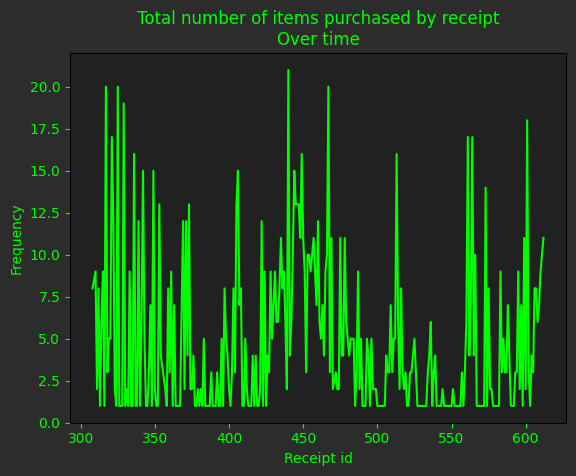

In [164]:
# plotting Total_Nbr_of_Items to see if there is seasonality or significant trends
# This will determine whether a time series type of analysis should be employed or not

# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

x.Total_Nbr_of_Items.plot(ax=ax,kind='line',
                      color='lime',
                      ylabel='Frequency',
                      xlabel='Receipt id',
                      title='Total number of items purchased by receipt\nOver time')

<p style="color: black;">
With the exception of a few features,Total_Nbr_of_Items and Total_Price are the<br>
main features from which the remaining features are sub features of,<br>
such that, they illustrate different aspects of these two features.
This is why only these two plots are used as checks for time series.<br><br>
The plots above show no indication of any seasonality or significant trends<br>
to suggest fitting a time series specific model.<br><br>
This confirms my initial intuition that although the data is collected over time<br>
My shopping habbits are not seasonal i.e. they don't change from year to year or season to season.<br><br>
The only area of concern here is the use of cross validation type of methods:<br>
randomisation in this instance would lead to future observations being used to predict<br>
the past i.e. using data that wouldn't otherwise be available at the point in time.<br><br>
However, given that my shopping habbits are not affected by time,<br>
this makes it acceptable to consider the data as <b>NOT</b> time series.<br>
Thus, it's ok to use cross validation.
</p>

In [147]:
# Drop receipt_id by dropping the index
raw1.reset_index(drop=True, inplace=True)

<h1 style="color: green;">Checking for and capping outliers</h1>

In [148]:
raw1.Education_exp_wk.value_counts()

0.00     804
51.96      4
12.99      3
39.93      2
19.98      2
27.98      2
29.99      2
7.98       1
9.99       1
16.99      1
19.99      1
11.99      1
27.00      1
53.99      1
2.49       1
Name: Education_exp_wk, dtype: int64

In [149]:
def detect_outlier(feature):
    outliers = []
    data = raw1[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    
    #print('\nOutlier caps for {}:'.format(feature))
    #print('  --80p: {:.1f} / {} values exceed that'.format(data.quantile(.80),
                                                             #len([i for i in data
                                                                  #if i > data.quantile(.80)])))    
    
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))

In [150]:
outlier_list = ['Total_Nbr_of_Items','Total_Price','Nbr_trips_per_wk','Nbr_items_per_wk',
                'Expenditure_per_wk','Electronics_exp_receipt','Electronics_exp_wk',
                'Education_exp_receipt','Education_exp_wk','DIY_exp_receipt','DIY_exp_wk',
                'Cosmetics_and_selfcare_exp_wk','Cosmetics_and_selfcare_exp_receipt']

for l in outlier_list:
    detect_outlier(l)


Outlier caps for Total_Nbr_of_Items:
  --95p: 17.0 / 41 values exceed that
  --3sd: 22.5 / 8 values exceed that
  --99p: 22.0 / 8 values exceed that

Outlier caps for Total_Price:
  --95p: 40.0 / 41 values exceed that
  --3sd: 246.6 / 8 values exceed that
  --99p: 146.1 / 9 values exceed that

Outlier caps for Nbr_trips_per_wk:
  --95p: 15.0 / 35 values exceed that
  --3sd: 17.6 / 18 values exceed that
  --99p: 18.0 / 0 values exceed that

Outlier caps for Nbr_items_per_wk:
  --95p: 56.0 / 26 values exceed that
  --3sd: 72.6 / 9 values exceed that
  --99p: 71.2 / 9 values exceed that

Outlier caps for Expenditure_per_wk:
  --95p: 267.7 / 40 values exceed that
  --3sd: 963.0 / 8 values exceed that
  --99p: 866.5 / 8 values exceed that

Outlier caps for Electronics_exp_receipt:
  --95p: 0.0 / 14 values exceed that
  --3sd: 43.5 / 7 values exceed that
  --99p: 25.0 / 9 values exceed that

Outlier caps for Electronics_exp_wk:
  --95p: 0.0 / 14 values exceed that
  --3sd: 51.1 / 8 values e

In [151]:
# capping outliers for Total_Nbr_of_Items at the 99th quantile
raw1['Total_Nbr_of_Items'].clip(upper=raw1['Total_Nbr_of_Items'].quantile(.99), inplace=True)

# capping outliers for Total_Price at the 95th quantile (a value of 35.2)
# this is more reasonable than the 99th quantile
raw1['Total_Price'].clip(upper=raw1['Total_Price'].quantile(.95), inplace=True)

# capping outliers for Nbr_trips_per_wk at the 95th quantile 
raw1['Nbr_trips_per_wk'].clip(upper=raw1['Nbr_trips_per_wk'].quantile(.95), inplace=True)

# capping outliers for Nbr_items_per_wk at the 95th quantile 
raw1['Nbr_items_per_wk'].clip(upper=raw1['Nbr_items_per_wk'].quantile(.95), inplace=True)

# capping outliers for Expenditure_per_wk at the 95th quantile 
raw1['Expenditure_per_wk'].clip(upper=raw1['Expenditure_per_wk'].quantile(.95), inplace=True)

# capping outliers for Electronics_exp_receipt at the 99th quantile 
raw1['Electronics_exp_receipt'].clip(upper=raw1['Electronics_exp_receipt'].quantile(.99), inplace=True)

# capping outliers for Electronics_exp_wk at the 99th quantile 
raw1['Electronics_exp_wk'].clip(upper=raw1['Electronics_exp_wk'].quantile(.99), inplace=True)

# capping outliers for Education_exp_receipt at the 99th quantile 
raw1['Education_exp_receipt'].clip(upper=raw1['Education_exp_receipt'].quantile(.99), inplace=True)

# capping outliers for Education_exp_wk at the 99th quantile 
raw1['Education_exp_wk'].clip(upper=raw1['Education_exp_wk'].quantile(.99), inplace=True)

# capping outliers for DIY_exp_receipt at the 99th quantile 
raw1['DIY_exp_receipt'].clip(upper=raw1['DIY_exp_receipt'].quantile(.99), inplace=True)

# capping outliers for DIY_exp_wk at the 99th quantile 
raw1['DIY_exp_wk'].clip(upper=raw1['DIY_exp_wk'].quantile(.99), inplace=True)

# capping outliers for Cosmetics_and_selfcare_exp_receipt at the 99th quantile 
raw1['Cosmetics_and_selfcare_exp_receipt'].clip(upper=raw1['Cosmetics_and_selfcare_exp_receipt'].quantile(.99), inplace=True)

# capping outliers for Cosmetics_and_selfcare_exp_wk at the 99th quantile 
raw1['Cosmetics_and_selfcare_exp_wk'].clip(upper=raw1['Cosmetics_and_selfcare_exp_wk'].quantile(.99), inplace=True)

In [152]:
raw1[['Venue_id','Total_Price']].query("Total_Price > 35.75")

,Venue_id,Total_Price
106,7,40.00
131,12,39.94
134,15,40.00
147,12,40.00
150,2,40.00
162,19,36.42
169,12,40.00
354,29,40.00
355,30,40.00
356,22,40.00


<h1 style="color: green;">Writing the analysis dataset to csv for modelling</h1>

In [153]:
raw1.to_csv("../Data/Model_data.csv",index=False)

In [154]:
raw1.shape

(827, 203)